# 패키지 불러오기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import warnings
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings(action='ignore') 

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

Using Device: cuda


# 데이터 관리

## 데이터 불러오기

In [3]:
df = pd.read_csv('./data.csv', encoding='cp949')
df.head()

,TAG_MIN,배정번호,건조 1존 OP,건조 2존 OP,건조로 온도 1 Zone,건조로 온도 2 Zone,세정기,소입1존 OP,소입2존 OP,소입3존 OP,...,소입로 CP 값,소입로 CP 모니터 값,소입로 온도 1 Zone,소입로 온도 2 Zone,소입로 온도 3 Zone,소입로 온도 4 Zone,솔트 컨베이어 온도 1 Zone,솔트 컨베이어 온도 2 Zone,솔트조 온도 1 Zone,솔트조 온도 2 Zone
0,2022-01-03 11:22:07,102410,75.6648,30.0155,NaN,NaN,68.4386,72.84030,59.7862,51.71690,...,0.450421,NaN,NaN,859.854,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-03 11:22:08,102410,75.6706,32.2732,NaN,NaN,68.4386,78.44150,61.6286,50.44530,...,0.450356,1.146260e-10,860.338,859.780,860.044,859.786,294.658,272.538,328.734,328.865
2,2022-01-03 11:22:09,102410,75.6776,32.1592,98.8533,99.14600,68.4386,78.10990,61.5414,52.01960,...,0.450341,1.145200e-10,860.338,859.780,859.981,859.724,294.658,272.538,328.734,328.805
3,2022-01-03 11:22:11,102410,75.8656,30.8312,98.7918,99.17675,68.4999,77.50725,60.6663,52.69425,...,0.450201,1.144670e-10,860.338,859.842,859.950,859.599,294.719,272.538,328.674,328.865
4,2022-01-03 11:22:12,102410,73.6468,29.5274,98.7918,99.20750,68.4386,76.02620,61.1634,51.69150,...,0.450235,1.145360e-10,860.351,859.791,859.991,859.731,294.721,272.599,328.740,328.808


# 데이터 전처리

## 결측치 처리

In [4]:
df.drop(['TAG_MIN', '배정번호',], inplace=True, axis=1)

In [5]:
df.isnull().sum()

건조 1존 OP                1
건조 2존 OP                1
건조로 온도 1 Zone         116
건조로 온도 2 Zone         148
세정기                    91
소입1존 OP              4288
소입2존 OP                 0
소입3존 OP                 2
소입4존 OP                 3
소입로 CP 값                1
소입로 CP 모니터 값          147
소입로 온도 1 Zone         130
소입로 온도 2 Zone         128
소입로 온도 3 Zone         157
소입로 온도 4 Zone         170
솔트 컨베이어 온도 1 Zone     106
솔트 컨베이어 온도 2 Zone     142
솔트조 온도 1 Zone         209
솔트조 온도 2 Zone         203
dtype: int64

### 선형 보간법

In [6]:
df = df.interpolate(method='values')

In [7]:
df.dropna(axis=0, inplace=True)

## 데이터 라벨링

In [8]:
df['IQR이상치개수'] =0
for col in df.columns:
    thirdq, firstq = df[col].quantile(0.75), df[col].quantile(0.25)
    interquartilerange = 1.5 * (thirdq - firstq)
    outlierhigh, outlierlow = interquartilerange + thirdq, firstq - interquartilerange

    outlier_indices = df[(df[col] > outlierhigh) | (df[col] < outlierlow)].index
    for idx in outlier_indices:
        df.loc[idx, 'IQR이상치개수'] += 1
print(df['IQR이상치개수'].value_counts())

IQR이상치개수
0     1524840
1      483793
2      368608
3      309354
4      134337
5       63736
7       31841
8       14441
9        5351
10       1867
11        678
12        424
13        287
14        163
Name: count, dtype: int64


In [9]:
from scipy.stats import zscore

# z-score 계산
z_scores = np.abs(zscore(df))
# z-score가 3보다 큰 값을 이상치로 판단
df['z-score이상치개수'] = (z_scores > 3).sum(axis=1)
print(df['z-score이상치개수'].value_counts())

z-score이상치개수
0     2311088
1      309634
2      239019
3       48821
4       16471
5        9843
6        2716
8         695
7         500
9         326
10        202
11        180
12        156
13         69
Name: count, dtype: int64


In [10]:
# 
df['z_anomaly'] = np.where(df['z-score이상치개수'] < 9, 0, 1)
df['IQR_anomaly'] =np.where(df['IQR이상치개수'] < 9, 0, 1)

In [11]:
df['설비 이상신호'] = np.where((df['z_anomaly']==1) & (df['IQR_anomaly']==1), 1, 0)

In [12]:
normal = df.loc[df['설비 이상신호'] ==0]
abnormal = df.loc[df['설비 이상신호'] ==1]
print('정상 데이터:', len(normal))
print('설비이상 데이터:', len(abnormal))

정상 데이터: 2938787
설비이상 데이터: 933


In [13]:
normal.drop(['IQR이상치개수','z-score이상치개수','z_anomaly','IQR_anomaly'], axis=1, inplace=True)
abnormal.drop(['IQR이상치개수','z-score이상치개수','z_anomaly','IQR_anomaly'], axis=1, inplace=True)

## 데이터셋 분할

In [14]:
train_Y, test_Y = train_test_split(normal, test_size =0.2, random_state =1)
print('학습 데이터셋 개수:', len(train_Y))
print('테스트 데이터셋 개수:', len(test_Y))

학습 데이터셋 개수: 2351029
테스트 데이터셋 개수: 587758


In [15]:
# 스케일링
scaler = MinMaxScaler()
# 정상 학습데이터 스케일링
normal_train_scaled = scaler.fit_transform(train_Y.iloc[:,:-1])
X_normal_train = pd.DataFrame(data=normal_train_scaled, index=train_Y.iloc[:,:-1].index, columns=train_Y.iloc[:,:-1].columns)
# 정상 학습데이터 y 값 설정
y_normal_train = train_Y.iloc[:,-1]
# 최종 정상 학습데이터
train_Y_normal = pd.concat([X_normal_train, y_normal_train], axis=1)
# 정상 테스트데이터 스케일링
normal_test_scaled = scaler.transform(test_Y.iloc[:,:-1])
X_normal_test = pd.DataFrame(data=normal_test_scaled, index=test_Y.iloc[:,:-1].index, columns=test_Y.iloc[:,:-1].columns)
# 정상 테스트데이터 y 값 설정
y_normal_test = test_Y.iloc[:,-1]
# 최종 정상 테스트데이터
test_Y_normal = pd.concat([X_normal_test, y_normal_test], axis=1)
# 비정상 테스트 데이터 스케일링
abnormal_test_scaled = scaler.transform(abnormal.iloc[:, :-1])
X_abnormal_test = pd.DataFrame(data=abnormal_test_scaled, index=abnormal.iloc[:, :-1].index,
columns=abnormal.iloc[:, :-1].columns)
# y 값 설정
y_abnormal_test = abnormal.iloc[:,-1]
# 최종 비정상 테스트데이터
abnormal_data = pd.concat([X_abnormal_test, y_abnormal_test], axis=1)

# 데이터 학습 및 검증

## 데이터 로더 정의

In [16]:
class CustomDataset(Dataset):
    def __init__(self, trainDF):
        self.df = trainDF

        self.inp = trainDF.values
        self.outp = trainDF.values
    def __len__(self):
		# 가지고 있는 데이터셋의 길이를 반환한다.
        return len(self.inp) # 1314
    def __getitem__(self,idx):
        inp = torch.FloatTensor(self.inp[idx])
        outp = torch.FloatTensor(self.outp[idx])
        return inp, outp # 해당하는 idx(인덱스)의 input과 output 데이터를 반환한다.

In [17]:
train_x, test_x = train_test_split(X_normal_train, test_size =0.2, random_state =1)

In [18]:
train_dataset = CustomDataset(train_x)
train_val_dataset = CustomDataset(test_x)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
train_val_dataloader = DataLoader(train_dataset, batch_size=64)

## Autoencoder

### Model Define

In [206]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.channel_num_in = 19

        self.encoder = nn.Sequential(
            nn.Linear(self.channel_num_in, 20),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.BatchNorm1d(5),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(5, 10),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            nn.Linear(20, self.channel_num_in),
            nn.BatchNorm1d(self.channel_num_in),
            nn.ReLU(),
            
        )

    def forward(self, x):
        f = self.encoder(x)
        output = self.decoder(f)
        return output

### Model Train

In [384]:
model = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) 
# Adam()을 최적화함수로 사용합니다. Adam은 SGD의 변형함수이며 학습중인 기울기를 참고하여 학습 속도를 자동으로 변화시킵니다.
criterion = nn.MSELoss() #원본값과 디코더에서 나온 값의 차이를 계산하기 위해 평균제곱오차(Mean Squared Loss) 오차함수를 사용합니다.
num_epochs = 50

RuntimeError: Expected one of cpu, cuda, ipu, xpu, mkldnn, opengl, opencl, ideep, hip, ve, fpga, ort, xla, lazy, vulkan, mps, meta, hpu, mtia, privateuseone device type at start of device string: CPU

In [208]:
model.train(True)
best_model = None
best_loss = float('inf')
increasing_loss_count = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, (data, targets) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        outputs = model(data)
        loss = criterion(outputs, targets)
        
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, targets in train_val_dataloader:
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)
            outputs = model(data)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(train_val_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Check if validation loss has increased
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_model = model
        increasing_loss_count = 0
    else:
        increasing_loss_count += 1

    # Early stopping condition
    if increasing_loss_count >= 5:
        print("Early stopping due to increase in validation loss for 10 consecutive epochs.")
        break

    model.train(True)

# Return the best model
torch.save(best_model.state_dict(), 'AE_IQR_Z_all99.pth')

Epoch 1/50: 100%|████████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 495.80it/s]


Epoch [1/50], Train Loss: 0.0348, Val Loss: 0.0126


Epoch 2/50: 100%|████████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 497.82it/s]


Epoch [2/50], Train Loss: 0.0108, Val Loss: 0.0069


Epoch 3/50: 100%|████████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 495.78it/s]


Epoch [3/50], Train Loss: 0.0060, Val Loss: 0.0039


Epoch 4/50: 100%|████████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 496.39it/s]


Epoch [4/50], Train Loss: 0.0039, Val Loss: 0.0027


Epoch 5/50: 100%|████████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 497.07it/s]


Epoch [5/50], Train Loss: 0.0027, Val Loss: 0.0018


Epoch 6/50: 100%|████████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 496.73it/s]


Epoch [6/50], Train Loss: 0.0022, Val Loss: 0.0016


Epoch 7/50: 100%|████████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 496.31it/s]


Epoch [7/50], Train Loss: 0.0021, Val Loss: 0.0016


Epoch 8/50: 100%|████████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 496.53it/s]


Epoch [8/50], Train Loss: 0.0020, Val Loss: 0.0017


Epoch 9/50: 100%|████████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 496.21it/s]


Epoch [9/50], Train Loss: 0.0020, Val Loss: 0.0016


Epoch 10/50: 100%|███████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 496.36it/s]


Epoch [10/50], Train Loss: 0.0020, Val Loss: 0.0015


Epoch 11/50: 100%|███████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 496.05it/s]


Epoch [11/50], Train Loss: 0.0019, Val Loss: 0.0015


Epoch 12/50: 100%|███████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 496.44it/s]


Epoch [12/50], Train Loss: 0.0019, Val Loss: 0.0015


Epoch 13/50: 100%|███████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 496.50it/s]


Epoch [13/50], Train Loss: 0.0019, Val Loss: 0.0015


Epoch 14/50: 100%|███████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 496.06it/s]


Epoch [14/50], Train Loss: 0.0019, Val Loss: 0.0015


Epoch 15/50: 100%|███████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 496.77it/s]


Epoch [15/50], Train Loss: 0.0019, Val Loss: 0.0015


Epoch 16/50: 100%|███████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 496.97it/s]


Epoch [16/50], Train Loss: 0.0019, Val Loss: 0.0015


Epoch 17/50: 100%|███████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 496.36it/s]


Epoch [17/50], Train Loss: 0.0019, Val Loss: 0.0015


Epoch 18/50: 100%|███████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 495.72it/s]


Epoch [18/50], Train Loss: 0.0019, Val Loss: 0.0014


Epoch 19/50: 100%|███████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 494.14it/s]


Epoch [19/50], Train Loss: 0.0019, Val Loss: 0.0014


Epoch 20/50: 100%|███████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 495.97it/s]


Epoch [20/50], Train Loss: 0.0019, Val Loss: 0.0015


Epoch 21/50: 100%|███████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 496.81it/s]


Epoch [21/50], Train Loss: 0.0018, Val Loss: 0.0015


Epoch 22/50: 100%|███████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 496.30it/s]


Epoch [22/50], Train Loss: 0.0018, Val Loss: 0.0015


Epoch 23/50: 100%|███████████████████████████████████████████████████| 29388/29388 [00:59<00:00, 495.56it/s]


Epoch [23/50], Train Loss: 0.0018, Val Loss: 0.0015
Early stopping due to increase in validation loss for 10 consecutive epochs.


### 모델 inference

In [518]:
def score(model, dataloader):
    model.eval()  # 모델을 평가 모드로 설정
    total_scores = []
    
    with torch.no_grad():
        for data, _ in dataloader:  # 라벨이 없다고 가정
            data = data.to(DEVICE)
            outputs = model(data)
            
            # 복원 오차 계산
            reconstruction_error = (data - outputs).pow(2).mean(dim=1).cpu().numpy()
            total_scores.extend(reconstruction_error)
    
    return np.array(total_scores)

In [519]:
AEmodel = Autoencoder() 
AEmodel.load_state_dict(torch.load('AE_IQR_Z_all99.pth'))
AEmodel.to(DEVICE) 

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=19, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
    (4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=5, bias=True)
    (7): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=20, bias=True)
    (4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=19, bias=True)
    (7): BatchNorm1d(19, eps=1e-05, momentum=0.1, a

In [520]:
X_normal_train_dataset = CustomDataset(X_normal_train)
X_normal_dataset = CustomDataset(X_normal_test)
X_normal_train_loader = DataLoader(X_normal_train_dataset, batch_size=64, shuffle=False)
X_normal_test_loader = DataLoader(X_normal_dataset, batch_size=64)
abnormal_df =abnormal_data.copy()
# 불필요한 변수 삭제
abnormal_df = abnormal_df.drop(['설비 이상신호'], axis=1)
abnomal_dataset = CustomDataset(abnormal_df)
abnomal_dataloader = DataLoader(abnomal_dataset, batch_size=256)
# 모두 비정상 값 복원오차 값 도출
ae_abnormal = score(AEmodel, abnomal_dataloader)

In [521]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)   # Time evaluation 
starter.record()

ae_train = score(AEmodel, X_normal_train_loader)
ae_test = score(AEmodel, X_normal_test_loader)
ae_abnormal = score(AEmodel, abnomal_dataloader)

ender.record()
torch.cuda.synchronize()
curr_time = starter.elapsed_time(ender)
print(curr_time)

44792.09375


In [522]:
true = np.concatenate([np.zeros(len(y_normal_train)), np.zeros(len(y_normal_test)), np.ones(len(abnormal_data))])
ae_scores = np.hstack([ae_train, ae_test, ae_abnormal])

fpr,tpr, threshold= roc_curve(true,ae_scores,pos_label=1)
distance = np.sqrt((1-tpr)**2+fpr**2)

best_threshold = threshold[np.argmin(distance)]

In [523]:
# 임계값은 0.03로 함

df['z_anomaly'] = np.where(df['z-score이상치개수'] < 9, 0, 1)
df['IQR_anomaly'] =np.where(df['IQR이상치개수'] < 9, 0, 1)

merged_data = pd.concat([X_normal_train, X_normal_test])
ae_scores = pd.DataFrame(index=merged_data.index)
ae_scores['score'] = list(np.hstack([ae_train, ae_test]))

# 설정한 임계값 보다 큰 경우 비정상
ae_scores['anomaly'] = best_threshold < ae_scores['score']
ae_scores.head()

,score,anomaly
796230,0.003325,False
2462292,0.000398,False
1867287,0.000833,False
1006252,0.001292,False
1190323,0.000320,False


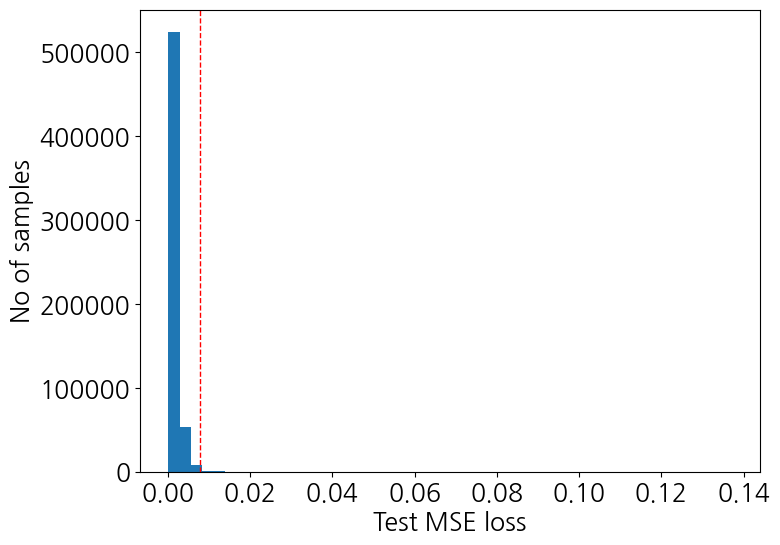

 test 데이터의 불량예측 개수:  0.0


In [524]:
# 시각화
plt.figure(figsize=(8,6))
plt.hist(ae_test, bins=50)
plt.xlabel("Test MSE loss")
plt.ylabel("No of samples")
plt.axvline(best_threshold, color='red', linestyle='--', linewidth=1)
plt.show()
# test 데이터의 불량 갯수(임계치 기준)
test_Y_normal = ae_test >best_threshold
print(" test 데이터의 불량예측 개수: ", np.median(test_Y_normal))

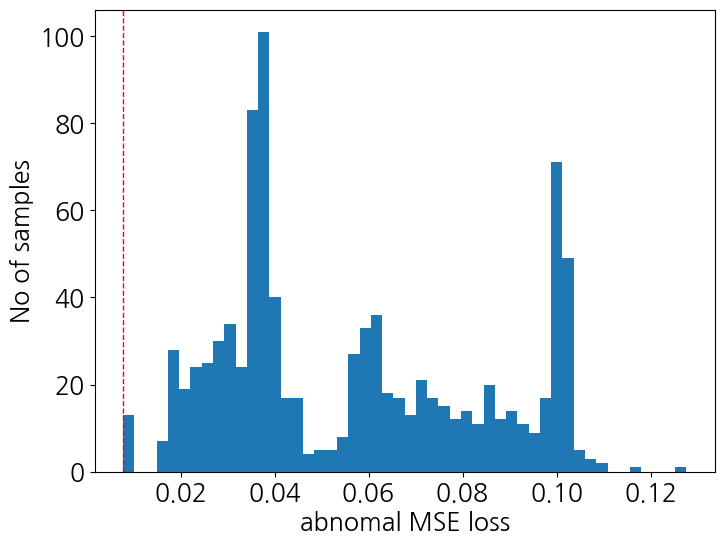

이상점으로 예측한 개수:  932


In [525]:
# 모두 비정상인 값 예측
# 시각화
plt.figure(figsize=(8,6))
plt.hist(ae_abnormal, bins=50)
plt.xlabel("abnomal MSE loss")
plt.ylabel("No of samples")
plt.axvline(best_threshold, color='red', linestyle='--', linewidth=1)
plt.show()
# 이상점으로 판단한 데이터 확인
test_N_abnormal = ae_abnormal > best_threshold
print("이상점으로 예측한 개수: ", np.sum(test_N_abnormal))

In [526]:
from sklearn.metrics import confusion_matrix
# 결과 값을 통한 정량적 지표 확인
# 실제 양품 불량으로 결합
true = np.concatenate([np.zeros(len(y_normal_test)), np.ones(len(abnormal_data))])
# 예측한 양품, 불량으로 결합
prediction = np.concatenate([test_Y_normal, test_N_abnormal])
aepredict = prediction
# 혼동 행렬
confusion_matrix(true, prediction)

array([[585283,   2475],
       [     1,    932]])

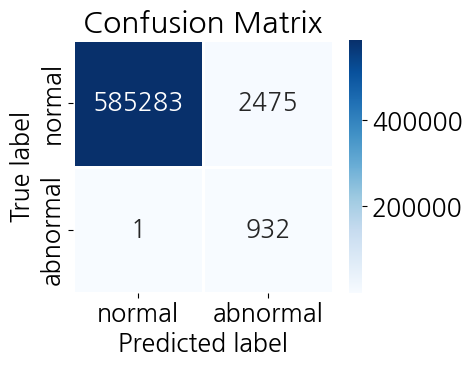

In [527]:
cm = confusion_matrix(true, prediction)
class_names=['normal', 'abnormal']
fig = plt.figure(figsize=(5,4))
ax = sns.heatmap(cm, annot=True, cmap='Blues', linewidths=1, fmt="d",
 xticklabels=['normal', 'abnormal'], yticklabels=['normal', 'abnormal'])
ax.set(title='Confusion Matrix',
 ylabel='True label',
 xlabel='Predicted label')
plt.tight_layout()
plt.savefig('AE_99.png')


In [528]:
from sklearn.metrics import classification_report
print(classification_report(true, prediction, target_names=['normal', 'abnormal']))

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00    587758
    abnormal       0.27      1.00      0.43       933

    accuracy                           1.00    588691
   macro avg       0.64      1.00      0.71    588691
weighted avg       1.00      1.00      1.00    588691



## memAE

### Model Define 

In [233]:
from memory_module import MemModule

# mean square error (MSE) is measure of the reconstruction quality (the crietrion for anomaly detection)


class MEMAE(nn.Module):
    def __init__(self):
        super(MEMAE, self).__init__()
        self.channel_num_in = 19

        self.encoder = nn.Sequential(
            nn.Linear(self.channel_num_in, 20),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.BatchNorm1d(5),
            nn.ReLU()
        )

        mem_dim = 280

        self.mem_rep = MemModule(mem_dim=mem_dim, fea_dim=5)

        self.decoder = nn.Sequential(
            nn.Linear(5, 10),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            nn.Linear(20, self.channel_num_in),
            nn.BatchNorm1d(self.channel_num_in),
            nn.ReLU()
        )

    def forward(self, x):
        f = self.encoder(x)
        res_mem = self.mem_rep(f)
        f = res_mem['output']
        att = res_mem['att']
        output = self.decoder(f)
        return {'output': output, 'att': att}

    def compute_loss(self, outputs, target):
        output = outputs['output']
        att = outputs['att']
        # loss = reconsturction loss + entropy of w
        recon_loss = torch.nn.MSELoss()(output, target)
        entropy_loss = torch.mean((-att) * torch.log(att + 1e-12))
        loss = recon_loss + 0.0002*entropy_loss

        return loss

    def compute_batch_error(self, outputs, target):
        output = outputs['output']
        loss = torch.nn.MSELoss(reduction='none')(output, target)
        batch_error = loss.mean(1)
        return batch_error


if __name__ == "__main__":
    model = MEMAE()
    print(model)

MEMAE(
  (encoder): Sequential(
    (0): Linear(in_features=19, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
    (4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=5, bias=True)
    (7): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (mem_rep): MemModule(
    (memory): MemoryUnit(mem_dim=280, fea_dim=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=20, bias=True)
    (4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_f

### Model Train

In [234]:

model = MEMAE().to(DEVICE)

model.train(True)
best_model = None
best_loss = float('inf')
increasing_loss_count = 0

train_losses = []
val_losses = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, (data, targets) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        outputs = model(data)
        loss = model.compute_loss(outputs, targets)
        
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, targets in train_val_dataloader:
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)
            outputs = model(data)
            loss = model.compute_loss(outputs, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(train_val_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    
    # Check if validation loss has increased
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_model = model
        increasing_loss_count = 0
    else:
        increasing_loss_count += 1

    # Early stopping condition
    if increasing_loss_count >= 5:
        print("Early stopping due to increase in validation loss for 10 consecutive epochs.")
        break

    model.train(True)

# Return the best model
torch.save(best_model.state_dict(), 'mAE_IQR_Z_all99.pth')

Epoch 1/100: 100%|███████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 375.44it/s]


Epoch [1/100], Train Loss: 0.040326, Val Loss: 0.010347


Epoch 2/100: 100%|███████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 376.46it/s]


Epoch [2/100], Train Loss: 0.010931, Val Loss: 0.008033


Epoch 3/100: 100%|███████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 376.21it/s]


Epoch [3/100], Train Loss: 0.008304, Val Loss: 0.005578


Epoch 4/100: 100%|███████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 375.22it/s]


Epoch [4/100], Train Loss: 0.005392, Val Loss: 0.003478


Epoch 5/100: 100%|███████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 375.91it/s]


Epoch [5/100], Train Loss: 0.003932, Val Loss: 0.002893


Epoch 6/100: 100%|███████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 376.01it/s]


Epoch [6/100], Train Loss: 0.003374, Val Loss: 0.002863


Epoch 7/100: 100%|███████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 375.00it/s]


Epoch [7/100], Train Loss: 0.003135, Val Loss: 0.002515


Epoch 8/100: 100%|███████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 376.55it/s]


Epoch [8/100], Train Loss: 0.002986, Val Loss: 0.002442


Epoch 9/100: 100%|███████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 375.58it/s]


Epoch [9/100], Train Loss: 0.002870, Val Loss: 0.002270


Epoch 10/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 375.79it/s]


Epoch [10/100], Train Loss: 0.002678, Val Loss: 0.002157


Epoch 11/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:17<00:00, 377.14it/s]


Epoch [11/100], Train Loss: 0.002597, Val Loss: 0.002123


Epoch 12/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 375.88it/s]


Epoch [12/100], Train Loss: 0.002352, Val Loss: 0.001647


Epoch 13/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 376.19it/s]


Epoch [13/100], Train Loss: 0.002083, Val Loss: 0.001611


Epoch 14/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 376.34it/s]


Epoch [14/100], Train Loss: 0.002028, Val Loss: 0.001539


Epoch 15/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 376.00it/s]


Epoch [15/100], Train Loss: 0.001997, Val Loss: 0.001533


Epoch 16/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:17<00:00, 377.42it/s]


Epoch [16/100], Train Loss: 0.001984, Val Loss: 0.001607


Epoch 17/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 376.07it/s]


Epoch [17/100], Train Loss: 0.001977, Val Loss: 0.001486


Epoch 18/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 376.54it/s]


Epoch [18/100], Train Loss: 0.001967, Val Loss: 0.001591


Epoch 19/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:17<00:00, 376.80it/s]


Epoch [19/100], Train Loss: 0.001963, Val Loss: 0.001500


Epoch 20/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 376.24it/s]


Epoch [20/100], Train Loss: 0.001953, Val Loss: 0.001507


Epoch 21/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 376.28it/s]


Epoch [21/100], Train Loss: 0.001942, Val Loss: 0.001489


Epoch 22/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 375.92it/s]


Epoch [22/100], Train Loss: 0.001934, Val Loss: 0.001454


Epoch 23/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 375.68it/s]


Epoch [23/100], Train Loss: 0.001927, Val Loss: 0.001462


Epoch 24/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:17<00:00, 376.96it/s]


Epoch [24/100], Train Loss: 0.001917, Val Loss: 0.001495


Epoch 25/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 376.24it/s]


Epoch [25/100], Train Loss: 0.001908, Val Loss: 0.001469


Epoch 26/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 375.84it/s]


Epoch [26/100], Train Loss: 0.001899, Val Loss: 0.001449


Epoch 27/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 375.84it/s]


Epoch [27/100], Train Loss: 0.001895, Val Loss: 0.001445


Epoch 28/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 376.71it/s]


Epoch [28/100], Train Loss: 0.001890, Val Loss: 0.001453


Epoch 29/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 376.35it/s]


Epoch [29/100], Train Loss: 0.001882, Val Loss: 0.001431


Epoch 30/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 376.36it/s]


Epoch [30/100], Train Loss: 0.001879, Val Loss: 0.001470


Epoch 31/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 375.98it/s]


Epoch [31/100], Train Loss: 0.001874, Val Loss: 0.001431


Epoch 32/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 375.20it/s]


Epoch [32/100], Train Loss: 0.001869, Val Loss: 0.001424


Epoch 33/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 375.97it/s]


Epoch [33/100], Train Loss: 0.001867, Val Loss: 0.001447


Epoch 34/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:17<00:00, 377.09it/s]


Epoch [34/100], Train Loss: 0.001867, Val Loss: 0.001391


Epoch 35/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 375.98it/s]


Epoch [35/100], Train Loss: 0.001866, Val Loss: 0.001477


Epoch 36/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 374.96it/s]


Epoch [36/100], Train Loss: 0.001864, Val Loss: 0.001442


Epoch 37/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 376.01it/s]


Epoch [37/100], Train Loss: 0.001863, Val Loss: 0.001393


Epoch 38/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 375.69it/s]


Epoch [38/100], Train Loss: 0.001864, Val Loss: 0.001402


Epoch 39/100: 100%|██████████████████████████████████████████████████| 29388/29388 [01:18<00:00, 376.38it/s]


Epoch [39/100], Train Loss: 0.001862, Val Loss: 0.001508
Early stopping due to increase in validation loss for 10 consecutive epochs.


### model inference

In [401]:
MAEmodel = MEMAE().to(DEVICE)  # 여기서 YourModelClass는 모델의 클래스 이름입니다.
MAEmodel.load_state_dict(torch.load('mAE_IQR_Z_all99.pth'))
MAEmodel.to(DEVICE)  # 모델을 원하는 디바이스로 이동

MEMAE(
  (encoder): Sequential(
    (0): Linear(in_features=19, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
    (4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=5, bias=True)
    (7): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (mem_rep): MemModule(
    (memory): MemoryUnit(mem_dim=280, fea_dim=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=20, bias=True)
    (4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_f

In [402]:
def score(model, dataloader):
    model.eval()  # 모델을 평가 모드로 설정
    total_scores = []
    
    with torch.no_grad():
        for data, _ in dataloader:  # 라벨이 없다고 가정
            data = data.to(DEVICE)
            outputs = model(data)
            
            # 복원 오차 계산
            reconstruction_error = (data - outputs['output']).pow(2).mean(dim=1).cpu().numpy()
            total_scores.extend(reconstruction_error)
            #append = np.append(append, outputs['output'].cpu().numpy())
    
    return np.array(total_scores), pd.DataFrame(data.cpu().numpy()), pd.DataFrame(outputs['output'].cpu().numpy())

In [403]:
X_normal_train_dataset = CustomDataset(X_normal_train)
X_normal_dataset = CustomDataset(X_normal_test)
X_normal_train_loader = DataLoader(X_normal_train_dataset, batch_size=64, shuffle=False)
X_normal_test_loader = DataLoader(X_normal_dataset, batch_size=64)

abnormal_df =abnormal_data.copy()
# 불필요한 변수 삭제
abnormal_df = abnormal_df.drop(['설비 이상신호'], axis=1)
abnomal_dataset = CustomDataset(abnormal_df)
abnomal_dataloader = DataLoader(abnomal_dataset, batch_size=64)

In [404]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)   # Time evaluation 
starter.record()


mae_train, mae_train_in, mae_train_out = score(MAEmodel, X_normal_train_loader)
mae_test, mae_test_in, mae_test_out= score(MAEmodel, X_normal_test_loader)
mae_abnormal, mae_an_in, mae_ab_out  = score(MAEmodel, abnomal_dataloader)

ender.record()
torch.cuda.synchronize()
curr_time = starter.elapsed_time(ender)
print(curr_time)

30315.037109375


In [239]:
true = np.concatenate([np.zeros(len(y_normal_train)), np.zeros(len(y_normal_test)), np.ones(len(abnormal_data))])
mae_scores = np.hstack([mae_train, mae_test, mae_abnormal])

fpr,tpr, threshold= roc_curve(true,mae_scores,pos_label=1)
distance = np.sqrt((1-tpr)**2+fpr**2)

best_threshold = threshold[np.argmin(distance)]

Text(0.5, 1.0, 'Test Data')

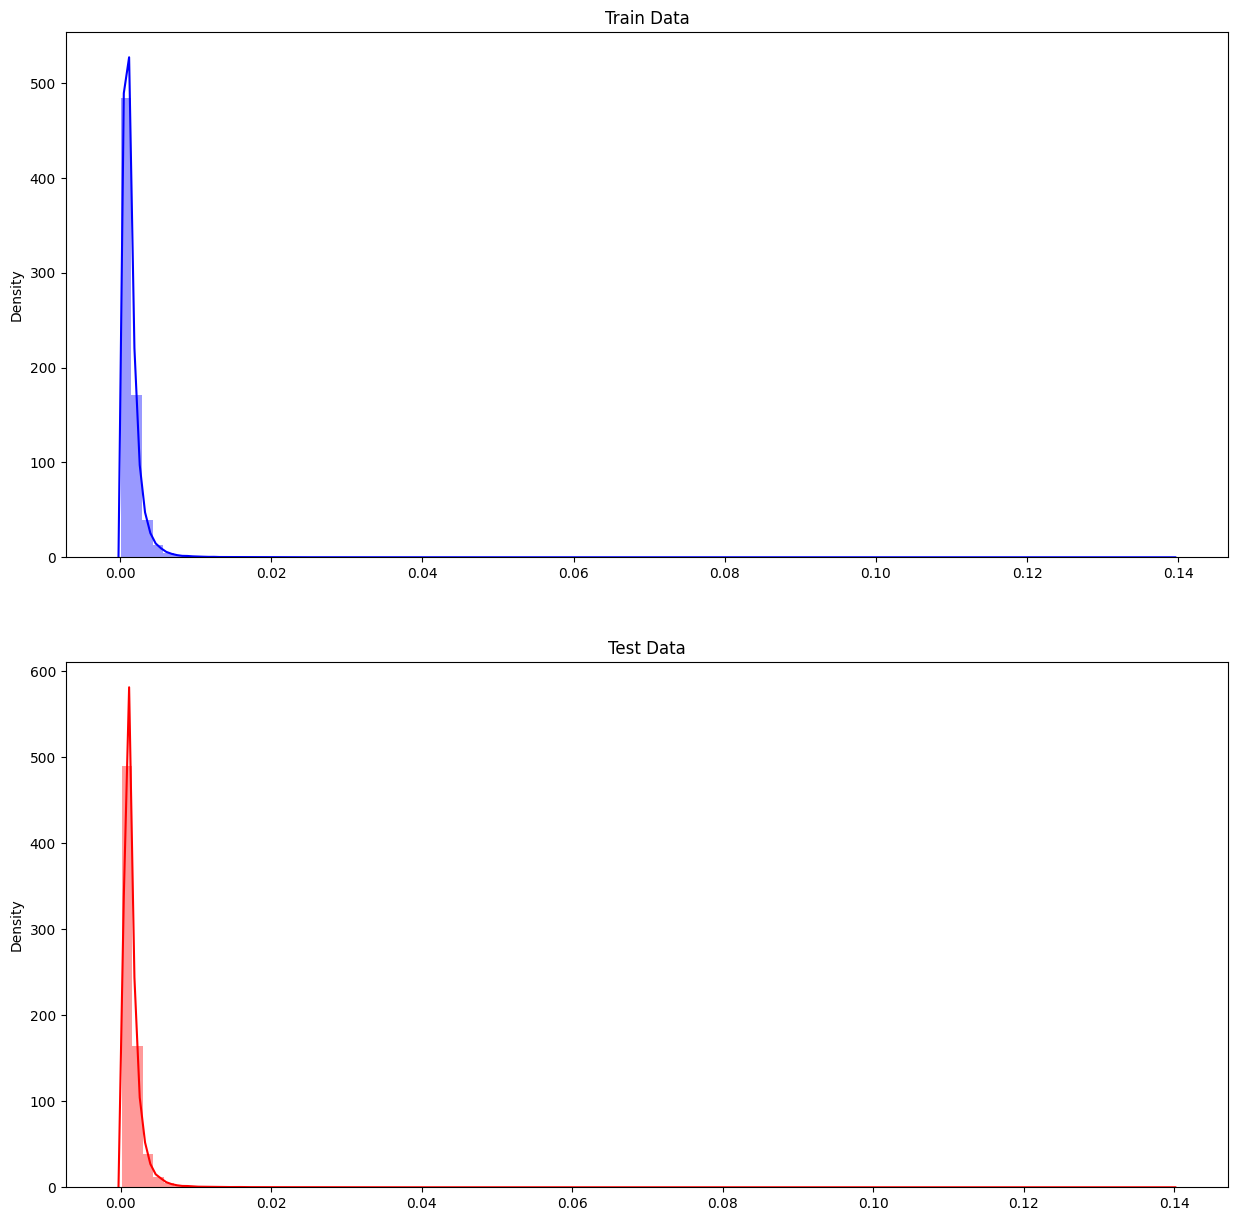

In [240]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15, 15))
sns.distplot(mae_train, bins=100, kde=True, color='blue', ax=ax1)
sns.distplot(mae_test, bins=100, kde=True, color='red', ax=ax2)
ax1.set_title("Train Data")
ax2.set_title("Test Data")

In [241]:
# 임계값은 0.03로 함
mmerged_data = pd.concat([X_normal_train, X_normal_test])
mae_scores = pd.DataFrame(index=mmerged_data.index)
mae_scores['score'] = list(np.hstack([mae_train, mae_test]))

mae_scores['anomaly'] = best_threshold < mae_scores['score']
mae_scores.head()

,score,anomaly
796230,0.002738,False
2462292,0.000668,False
1867287,0.000636,False
1006252,0.001404,False
1190323,0.000437,False


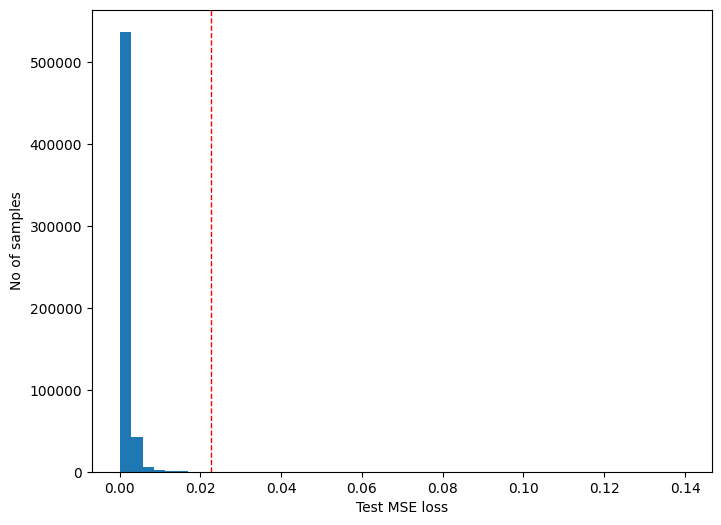

 test 데이터의 불량예측 개수:  258


In [242]:
# 시각화
plt.figure(figsize=(8,6))
plt.hist(mae_test, bins=50)
plt.xlabel("Test MSE loss")
plt.ylabel("No of samples")
plt.axvline(best_threshold, color='red', linestyle='--', linewidth=1)
plt.show()
# test 데이터의 불량 갯수(임계치 기준)
test_Y_normal = mae_test > best_threshold
print(" test 데이터의 불량예측 개수: ", np.sum(test_Y_normal))

In [243]:
abnormal_df =abnormal_data.copy()
# 불필요한 변수 삭제
abnormal_df = abnormal_df.drop(['설비 이상신호'], axis=1)
abnomal_dataset = CustomDataset(abnormal_df)
abnomal_dataloader = DataLoader(abnomal_dataset, batch_size=64)
# 모두 비정상 값 복원오차 값 도출
mae_abnormal, data, mae_abnomal_out= score(MAEmodel, abnomal_dataloader)

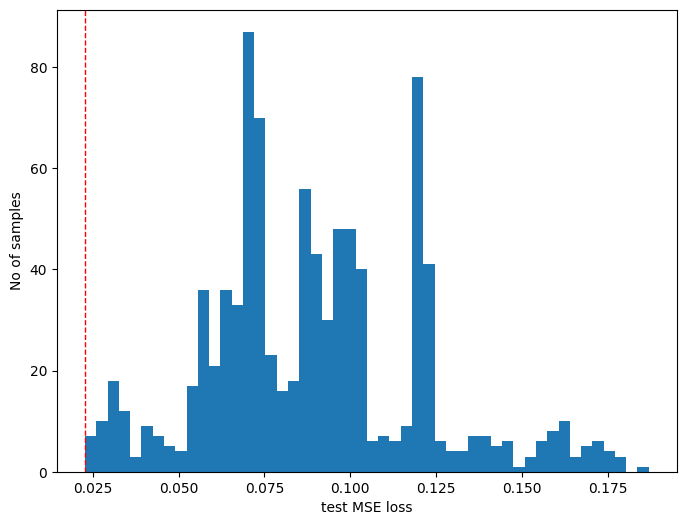

이상점으로 예측한 개수:  932


In [244]:
# 모두 비정상인 값 예측
# 시각화
plt.figure(figsize=(8,6))
plt.hist(mae_abnormal, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.axvline(best_threshold, color='red', linestyle='--', linewidth=1)
plt.show()
# 이상점으로 판단한 데이터 확인
test_N_abnormal = mae_abnormal >best_threshold
print("이상점으로 예측한 개수: ", np.sum(test_N_abnormal))

In [245]:
from sklearn.metrics import confusion_matrix
# 결과 값을 통한 정량적 지표 확인
# 실제 양품 불량으로 결합
true = np.concatenate([np.zeros(len(y_normal_test)), np.ones(len(abnormal_data))])
# 예측한 양품, 불량으로 결합
prediction = np.concatenate([test_Y_normal, test_N_abnormal])
maepredict = prediction
# 혼동 행렬
confusion_matrix(true, prediction)

array([[587500,    258],
       [     1,    932]])

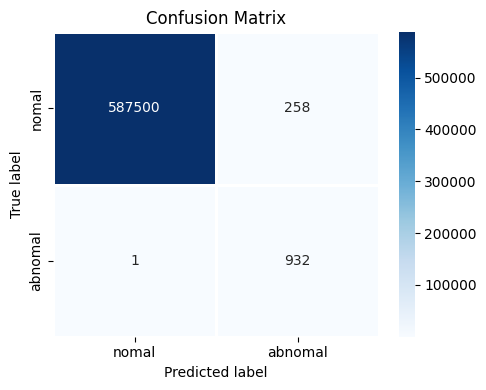

In [246]:
cm = confusion_matrix(true, prediction)
class_names=['nomal','abnomal']
fig = plt.figure(figsize=(5,4))
ax = sns.heatmap(cm, annot=True, cmap='Blues', linewidths=1, fmt="d",
 xticklabels=['nomal','abnomal'], yticklabels=['nomal','abnomal'])
ax.set(title='Confusion Matrix',
 ylabel='True label',
 xlabel='Predicted label')
plt.tight_layout()
plt.savefig('memAE_99.png')

In [247]:
from sklearn.metrics import classification_report
print(classification_report(true, prediction, target_names=['normal', 'abnormal']))

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00    587758
    abnormal       0.78      1.00      0.88       933

    accuracy                           1.00    588691
   macro avg       0.89      1.00      0.94    588691
weighted avg       1.00      1.00      1.00    588691



## Usad

### model define

In [364]:
class Encoder(nn.Module):
  def __init__(self, in_size):
    super().__init__()
    self.linear1 = nn.Linear(in_size, 20)    
    self.linear2 = nn.Linear(20, 10)
    self.linear3 = nn.Linear(10, 5)
    self.BN1= nn.BatchNorm1d(20)
    self.BN2= nn.BatchNorm1d(10)
    self.BN3= nn.BatchNorm1d(5)
    self.relu = nn.ReLU(True)

  def forward(self, w):
    out = self.linear1(w)
    out = self.BN1(out)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.BN2(out)
    out = self.relu(out)
    out = self.linear3(out)
    out = self.BN3(out)
    z = self.relu(out)
    return z

class Decoder(nn.Module):
  def __init__(self, out_size):
    super().__init__()
    self.linear1 = nn.Linear(5, 10)
    self.linear2 = nn.Linear(10, 20)
    self.linear3 = nn.Linear(20, out_size)
    self.relu = nn.ReLU(True)
    self.BN1= nn.BatchNorm1d(10)
    self.BN2= nn.BatchNorm1d(20)
    self.BN3= nn.BatchNorm1d(out_size)
    self.sigmoid = nn.Sigmoid()

  def forward(self, z):
    out = self.linear1(z)
    out = self.BN1(out)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.BN2(out)
    out = self.relu(out)
    out = self.linear3(out)
    out = self.BN3(out)  
    w = self.relu(out)
    return w
    
class UsadModel(nn.Module):
  def __init__(self, w_size):
    super().__init__()
    self.encoder = Encoder(w_size)
    self.decoder1 = Decoder(w_size)
    self.decoder2 = Decoder(w_size)
  
  def training_step(self, batch, n):
    z = self.encoder(batch)
    w1 = self.decoder1(z)
    w2 = self.decoder2(z)
    w3 = self.decoder2(self.encoder(w1))
    loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
    loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
    return loss1,loss2

  def validation_step(self, batch, n):
    with torch.no_grad():
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
        loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
    return {'val_loss1': loss1, 'val_loss2': loss2}
        
  def validation_epoch_end(self, outputs):
    batch_losses1 = [x['val_loss1'] for x in outputs]
    epoch_loss1 = torch.stack(batch_losses1).mean()
    batch_losses2 = [x['val_loss2'] for x in outputs]
    epoch_loss2 = torch.stack(batch_losses2).mean()
    return {'val_loss1': epoch_loss1.item(), 'val_loss2': epoch_loss2.item()}
    
  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss1: {:.4f}, val_loss2: {:.4f}".format(epoch, result['val_loss1'], result['val_loss2']))

### model Train

In [365]:
model = UsadModel(19).to(DEVICE)
model.train(True)
best_model = None
best_loss = float('inf')
increasing_loss_count = 0
num_epochs = 100
train_losses = []
val_losses = []
opt_func=torch.optim.Adam
optimizer1 = opt_func(list(model.encoder.parameters())+list(model.decoder1.parameters()))
optimizer2 = opt_func(list(model.encoder.parameters())+list(model.decoder2.parameters()))
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, (data, targets) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        loss1,loss2 = model.training_step(data,epoch+1)
        loss1.backward()
        optimizer1.step()
        optimizer1.zero_grad()

        loss1,loss2 = model.training_step(data,epoch+1)
        loss2.backward()
        optimizer2.step()
        optimizer2.zero_grad()
    
    model.eval()
    with torch.no_grad():
        outputs = []
        for data, targets in train_val_dataloader:
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)
            output = model.validation_step(data, epoch+1)
            outputs.append(output)
        result = model.validation_epoch_end(outputs)
            #val_losses.append(output)
        
        model.epoch_end(epoch, result)
    
    if result['val_loss2'] < best_loss:
        best_loss = result['val_loss2']
        best_model = model
        increasing_loss_count = 0
    else:
        increasing_loss_count += 1

    # Early stopping condition
    if increasing_loss_count >= 5:
        print("Early stopping due to increase in validation loss for 10 consecutive epochs.")
        break

    model.train(True)
        
torch.save(best_model.state_dict(), 'usad_IQR_Z_all99.pth')   

Epoch 1/100: 100%|███████████████████████████████████████████████████| 29388/29388 [03:29<00:00, 140.56it/s]


Epoch [0], val_loss1: 0.0023, val_loss2: 0.0022


Epoch 2/100: 100%|███████████████████████████████████████████████████| 29388/29388 [03:29<00:00, 140.37it/s]


Epoch [1], val_loss1: 0.0030, val_loss2: -0.0006


Epoch 3/100: 100%|███████████████████████████████████████████████████| 29388/29388 [03:29<00:00, 140.60it/s]


Epoch [2], val_loss1: 0.0039, val_loss2: -0.0021


Epoch 4/100: 100%|███████████████████████████████████████████████████| 29388/29388 [03:30<00:00, 139.93it/s]


Epoch [3], val_loss1: 0.0060, val_loss2: -0.0040


Epoch 5/100: 100%|███████████████████████████████████████████████████| 29388/29388 [03:27<00:00, 141.74it/s]


Epoch [4], val_loss1: 0.0097, val_loss2: -0.0066


Epoch 6/100: 100%|███████████████████████████████████████████████████| 29388/29388 [03:29<00:00, 140.39it/s]


Epoch [5], val_loss1: 0.0048, val_loss2: -0.0038


Epoch 7/100: 100%|███████████████████████████████████████████████████| 29388/29388 [03:29<00:00, 140.48it/s]


Epoch [6], val_loss1: 0.0041, val_loss2: -0.0033


Epoch 8/100: 100%|███████████████████████████████████████████████████| 29388/29388 [03:28<00:00, 141.27it/s]


Epoch [7], val_loss1: 0.0039, val_loss2: -0.0032


Epoch 9/100: 100%|███████████████████████████████████████████████████| 29388/29388 [03:29<00:00, 140.26it/s]


Epoch [8], val_loss1: 0.0052, val_loss2: -0.0044


Epoch 10/100: 100%|██████████████████████████████████████████████████| 29388/29388 [03:29<00:00, 140.39it/s]


Epoch [9], val_loss1: 0.0067, val_loss2: -0.0058
Early stopping due to increase in validation loss for 10 consecutive epochs.


### inference

In [409]:
USADmodel = UsadModel(19).to(DEVICE)  # 여기서 YourModelClass는 모델의 클래스 이름입니다.
USADmodel.load_state_dict(torch.load('usad_IQR_Z_all99.pth'))
USADmodel.to(DEVICE)  # 모델을 원하는 디바이스로 이동

UsadModel(
  (encoder): Encoder(
    (linear1): Linear(in_features=19, out_features=20, bias=True)
    (linear2): Linear(in_features=20, out_features=10, bias=True)
    (linear3): Linear(in_features=10, out_features=5, bias=True)
    (BN1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (BN2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (BN3): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (decoder1): Decoder(
    (linear1): Linear(in_features=5, out_features=10, bias=True)
    (linear2): Linear(in_features=10, out_features=20, bias=True)
    (linear3): Linear(in_features=20, out_features=19, bias=True)
    (relu): ReLU(inplace=True)
    (BN1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (BN2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (BN3): BatchNorm1d(19, eps

In [24]:
X_normal_train_dataset = CustomDataset(X_normal_train)
X_normal_dataset = CustomDataset(X_normal_test)
X_normal_train_loader = DataLoader(X_normal_train_dataset, batch_size=64, shuffle=False)
X_normal_test_loader = DataLoader(X_normal_dataset, batch_size=64)

abnormal_df =abnormal_data.copy()
# 불필요한 변수 삭제
abnormal_df = abnormal_df.drop(['설비 이상신호'], axis=1)
abnomal_dataset = CustomDataset(abnormal_df)
abnomal_dataloader = DataLoader(abnomal_dataset, batch_size=64)

In [412]:
def testing(model, test_loader, alpha=.9, beta=.1):
    results=[]
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(DEVICE)
            w1=model.decoder1(model.encoder(data))
            w2=model.decoder2(model.encoder(w1))
            reconstruction_error = alpha*torch.mean((data-w1)**2,axis=1)+beta*torch.mean((data-w2)**2,axis=1)
            results.extend(reconstruction_error.cpu().numpy())
    return results

In [413]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)   # Time evaluation 
starter.record()

usad_train = testing(USADmodel, X_normal_train_loader)
usad_test= testing(USADmodel, X_normal_test_loader)
usad_abnormal = testing(USADmodel, abnomal_dataloader)

ender.record()
torch.cuda.synchronize()
curr_time = starter.elapsed_time(ender)
print(curr_time)

36252.63671875


In [370]:

true = np.concatenate([np.zeros(len(y_normal_train)), np.zeros(len(y_normal_test)), np.ones(len(abnormal_data))])
usad_scores = np.hstack([usad_train, usad_test,usad_abnormal])

fpr,tpr, threshold= roc_curve(true,usad_scores,pos_label=1)
distance = np.sqrt((1-tpr)**2+fpr**2)

best_threshold = threshold[np.argmin(distance)]

Text(0.5, 1.0, 'Test Data')

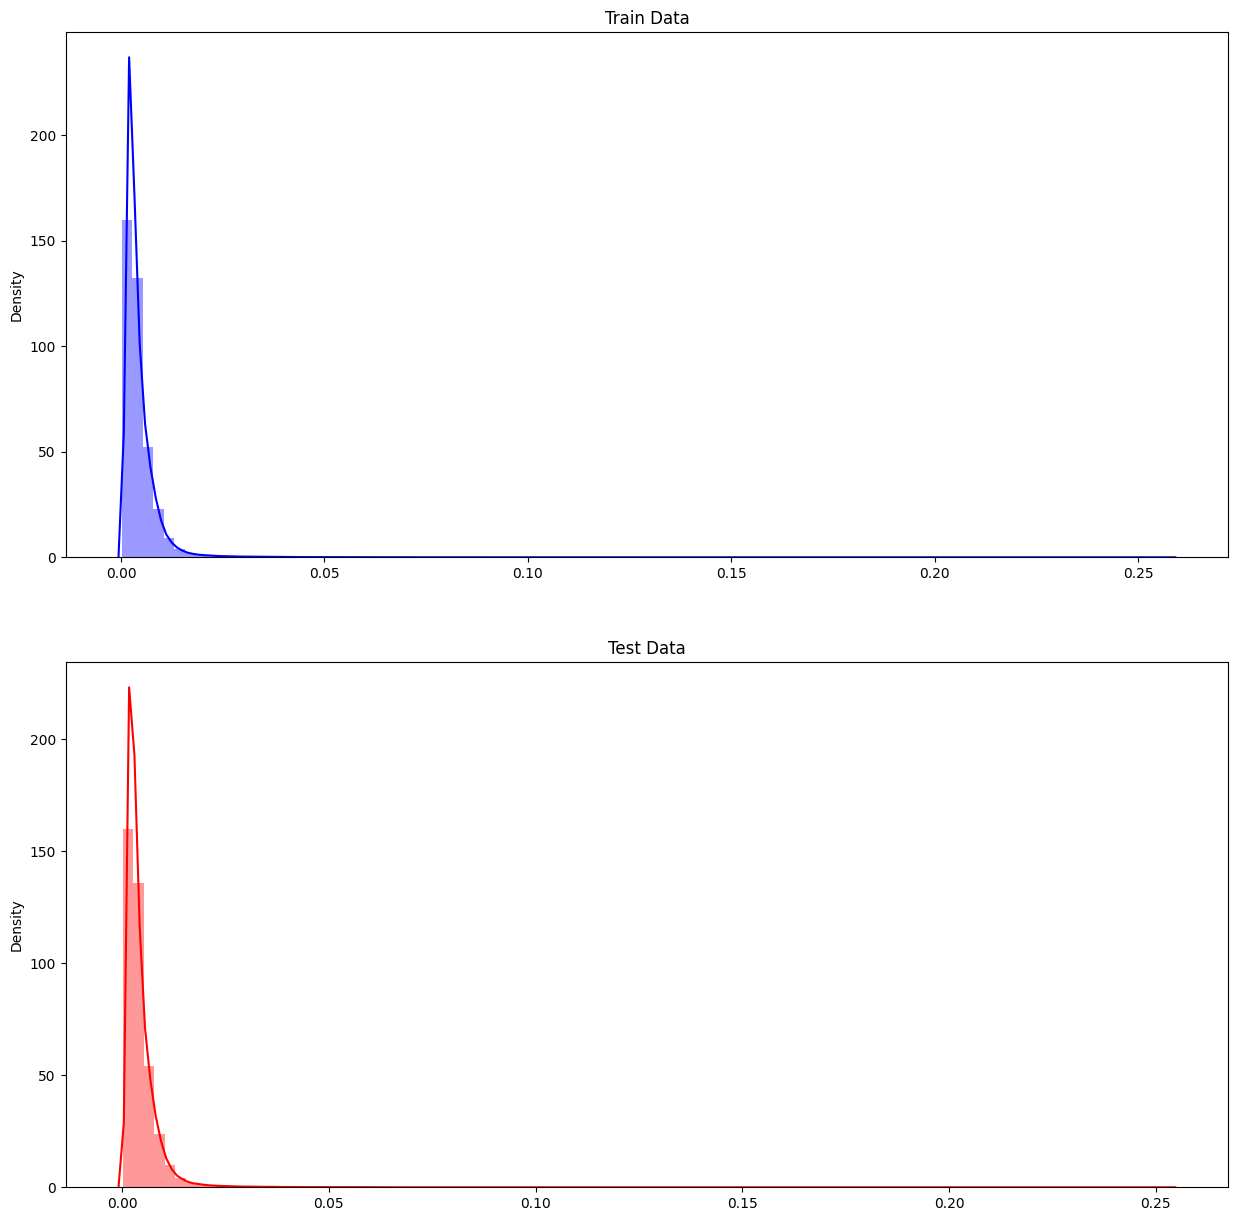

In [371]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15, 15))
sns.distplot(usad_train, bins=100, kde=True, color='blue', ax=ax1)
sns.distplot(usad_test, bins=100, kde=True, color='red', ax=ax2)
ax1.set_title("Train Data")
ax2.set_title("Test Data")

In [372]:
# 임계값은 0.03로 함
mmerged_data = pd.concat([X_normal_train, X_normal_test])
usad_scores = pd.DataFrame(index=mmerged_data.index)
usad_scores['score'] = list(np.hstack([usad_train, usad_test]))

usad_scores['anomaly'] = best_threshold < usad_scores['score']
usad_scores.head()

,score,anomaly
796230,0.006880,False
2462292,0.001249,False
1867287,0.002768,False
1006252,0.002804,False
1190323,0.000757,False


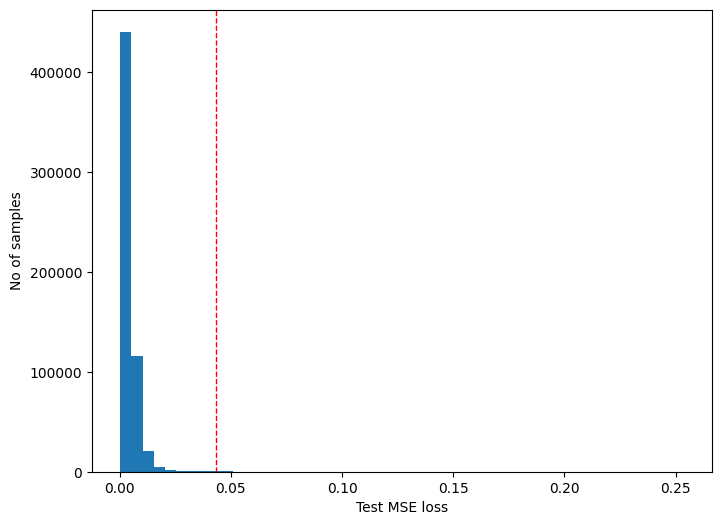

 test 데이터의 불량예측 개수:  988


In [373]:
# 시각화
plt.figure(figsize=(8,6))
plt.hist(usad_test, bins=50)
plt.xlabel("Test MSE loss")
plt.ylabel("No of samples")
plt.axvline(best_threshold, color='red', linestyle='--', linewidth=1)
plt.show()
# test 데이터의 불량 갯수(임계치 기준)
test_Y_normal = [x > best_threshold for x in usad_test]
print(" test 데이터의 불량예측 개수: ", np.sum(test_Y_normal))

In [374]:
abnormal_df =abnormal_data.copy()
# 불필요한 변수 삭제
abnormal_df = abnormal_df.drop(['설비 이상신호'], axis=1)
abnomal_dataset = CustomDataset(abnormal_df)
abnomal_dataloader = DataLoader(abnomal_dataset, batch_size=64)
# 모두 비정상 값 복원오차 값 도출
usad_abnormal = testing(USADmodel, abnomal_dataloader)

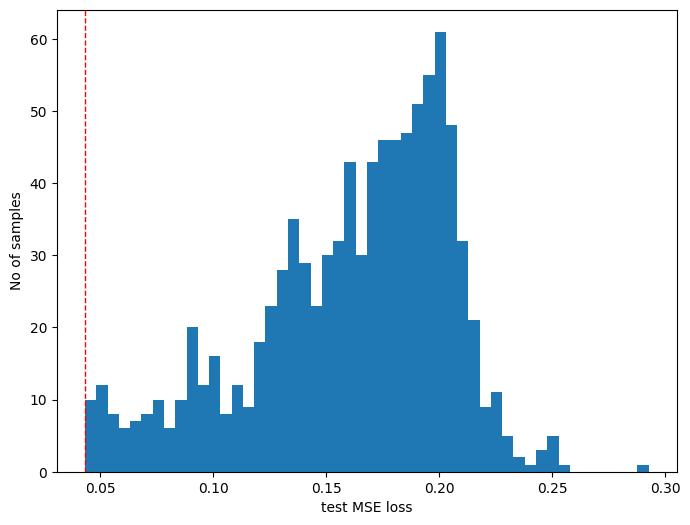

이상점으로 예측한 개수:  932


In [375]:
# 모두 비정상인 값 예측
# 시각화
plt.figure(figsize=(8,6))
plt.hist(usad_abnormal, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.axvline(best_threshold, color='red', linestyle='--', linewidth=1)
plt.show()
# 이상점으로 판단한 데이터 확인
test_N_abnormal = [x > best_threshold for x in usad_abnormal]
print("이상점으로 예측한 개수: ", np.sum(test_N_abnormal))

In [376]:
from sklearn.metrics import confusion_matrix
# 결과 값을 통한 정량적 지표 확인
# 실제 양품 불량으로 결합
true = np.concatenate([np.zeros(len(y_normal_test)), np.ones(len(abnormal_data))])
# 예측한 양품, 불량으로 결합
prediction = np.concatenate([test_Y_normal, test_N_abnormal])
usadpredict= prediction
# 혼동 행렬
confusion_matrix(true, prediction)

array([[586770,    988],
       [     1,    932]])

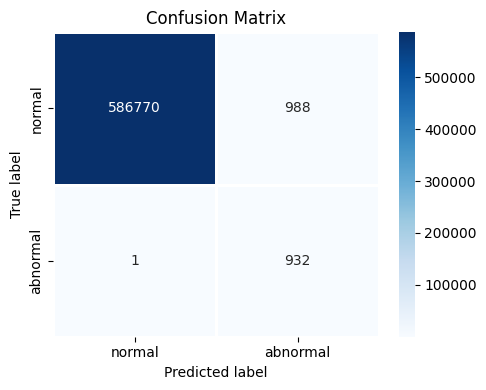

In [377]:
cm = confusion_matrix(true, prediction)
class_names=['normal', 'abnormal']
fig = plt.figure(figsize=(5,4))
ax = sns.heatmap(cm, annot=True, cmap='Blues', linewidths=1, fmt="d",
 xticklabels=['normal', 'abnormal'], yticklabels=['normal', 'abnormal'])
ax.set(title='Confusion Matrix',
 ylabel='True label',
 xlabel='Predicted label')
plt.tight_layout()
plt.savefig('USAD_99.png')

In [378]:
from sklearn.metrics import classification_report
print(classification_report(true, prediction, target_names=['normal', 'abnormal']))

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00    587758
    abnormal       0.49      1.00      0.65       933

    accuracy                           1.00    588691
   macro avg       0.74      1.00      0.83    588691
weighted avg       1.00      1.00      1.00    588691



## mem+usad

### model Define

In [20]:
from memory_module import MemModule

class Encoder(nn.Module):
  def __init__(self, in_size):
    super().__init__()
    self.linear1 = nn.Linear(in_size, 20)    
    self.linear2 = nn.Linear(20, 10)
    self.linear3 = nn.Linear(10, 5)
    self.BN1= nn.BatchNorm1d(20)
    self.BN2= nn.BatchNorm1d(10)
    self.BN3= nn.BatchNorm1d(5)
    self.relu = nn.ReLU(True)

  def forward(self, w):
    out = self.linear1(w)
    out = self.BN1(out)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.BN2(out)
    out = self.relu(out)
    out = self.linear3(out)
    out = self.BN3(out)
    z = self.relu(out)
    return z

class Decoder(nn.Module):
  def __init__(self, out_size):
    super().__init__()
    self.linear1 = nn.Linear(5, 10)
    self.linear2 = nn.Linear(10, 20)
    self.linear3 = nn.Linear(20, out_size)
    self.relu = nn.ReLU(True)
    self.BN1= nn.BatchNorm1d(10)
    self.BN2= nn.BatchNorm1d(20)
    self.BN3= nn.BatchNorm1d(out_size)
    self.sigmoid = nn.Sigmoid()

  def forward(self, z):
    out = self.linear1(z)
    out = self.BN1(out)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.BN2(out)
    out = self.relu(out)
    out = self.linear3(out)
    out = self.BN3(out)  
    w = self.relu(out)
    return w

class MUsadModel(nn.Module):
  def __init__(self, w_size):
    super().__init__()
    self.encoder = Encoder(w_size)
    self.mem_rep = MemModule(mem_dim=280, fea_dim=5)
    self.decoder1 = Decoder(w_size)
    self.decoder2 = Decoder(w_size)

  def training_step(self, batch, n):
    z = self.encoder(batch)
    res_mem = self.mem_rep(z)
    z = res_mem['output']
    att = res_mem['att']
    w1 = self.decoder1(z)
    w2 = self.decoder2(z)
    w3 = self.decoder2(self.encoder(w1))

    recon_loss1 = torch.nn.MSELoss()(w1, batch)
    recon_loss2 = torch.nn.MSELoss()(w2, batch)
    recon_loss3 = torch.nn.MSELoss()(w3, batch)
    entropy_loss = torch.mean((-att) * torch.log(att + 1e-12))

    memloss1 = recon_loss1 + 0.0002*entropy_loss
    memloss2 = recon_loss2 + 0.0002*entropy_loss
    memloss3 = recon_loss3 + 0.0002*entropy_loss

    loss1 = 1/n*memloss1+(1-1/n)*memloss3
    loss2 = 1/n*memloss2-(1-1/n)*memloss3
    return loss1,loss2

  def validation_step(self, batch, n):
    with torch.no_grad():
        z = self.encoder(batch)
        res_mem = self.mem_rep(z)
        z = res_mem['output']
        att = res_mem['att']
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))

        recon_loss1 = torch.nn.MSELoss()(w1, batch)
        recon_loss2 = torch.nn.MSELoss()(w2, batch)
        recon_loss3 = torch.nn.MSELoss()(w3, batch)
        entropy_loss = torch.mean((-att) * torch.log(att + 1e-12))

        memloss1 = recon_loss1 + 0.0002*entropy_loss
        memloss2 = recon_loss2 + 0.0002*entropy_loss
        memloss3 = recon_loss3 + 0.0002*entropy_loss

        
        loss1 = 1/n*memloss1+(1-1/n)*memloss3
        loss2 = 1/n*memloss2-(1-1/n)*memloss3
    return {'val_loss1': loss1, 'val_loss2': loss2}

  def validation_epoch_end(self, outputs):
    batch_losses1 = [x['val_loss1'] for x in outputs]
    epoch_loss1 = torch.stack(batch_losses1).mean()
    batch_losses2 = [x['val_loss2'] for x in outputs]
    epoch_loss2 = torch.stack(batch_losses2).mean()
    return {'val_loss1': epoch_loss1.item(), 'val_loss2': epoch_loss2.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss1: {:.4f}, val_loss2: {:.4f}".format(epoch, result['val_loss1'], result['val_loss2']))

### model Train

In [249]:

model = MUsadModel(19).to(DEVICE)

model.train(True)
best_model = None
best_loss = float('inf')
increasing_loss_count = 0
num_epochs = 100
train_losses = []
val_losses = []
opt_func=torch.optim.Adam
optimizer1 = opt_func(list(model.encoder.parameters())+list(model.decoder1.parameters()))
optimizer2 = opt_func(list(model.encoder.parameters())+list(model.decoder2.parameters()))
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, (data, targets) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        loss1,loss2 = model.training_step(data,epoch+1)
        loss1.backward()
        optimizer1.step()
        optimizer1.zero_grad()

        loss1,loss2 = model.training_step(data,epoch+1)
        loss2.backward()
        optimizer2.step()
        optimizer2.zero_grad()
    
    model.eval()
    with torch.no_grad():
        outputs = []
        for data, targets in train_val_dataloader:
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)
            output = model.validation_step(data, epoch+1)
            outputs.append(output)
        result = model.validation_epoch_end(outputs)
            #val_losses.append(output)
        
        model.epoch_end(epoch, result)
    
    if result['val_loss2'] < best_loss:
        best_loss = result['val_loss2']
        best_model = model
        increasing_loss_count = 0
    else:
        increasing_loss_count += 1

    # Early stopping condition
    if increasing_loss_count >= 5: 
        print("Early stopping due to increase in validation loss for 10 consecutive epochs.")
        break

    model.train(True)
        
torch.save(best_model.state_dict(), 'Musad_IQR_Z_all99.pth')   

Epoch 1/100: 100%|███████████████████████████████████████████████████| 29388/29388 [04:02<00:00, 121.03it/s]


Epoch [0], val_loss1: 0.0026, val_loss2: 0.0656


Epoch 2/100: 100%|███████████████████████████████████████████████████| 29388/29388 [04:06<00:00, 119.25it/s]


Epoch [1], val_loss1: 0.0269, val_loss2: 0.0237


Epoch 3/100: 100%|███████████████████████████████████████████████████| 29388/29388 [04:06<00:00, 119.11it/s]


Epoch [2], val_loss1: 0.0745, val_loss2: -0.0440


Epoch 4/100: 100%|███████████████████████████████████████████████████| 29388/29388 [04:06<00:00, 119.24it/s]


Epoch [3], val_loss1: 0.1373, val_loss2: -0.0921


Epoch 5/100: 100%|███████████████████████████████████████████████████| 29388/29388 [04:05<00:00, 119.89it/s]


Epoch [4], val_loss1: 0.1485, val_loss2: -0.1206


Epoch 6/100: 100%|███████████████████████████████████████████████████| 29388/29388 [04:06<00:00, 119.08it/s]


Epoch [5], val_loss1: 0.1120, val_loss2: -0.0746


Epoch 7/100: 100%|███████████████████████████████████████████████████| 29388/29388 [04:06<00:00, 118.99it/s]


Epoch [6], val_loss1: 0.1403, val_loss2: -0.1085


Epoch 8/100: 100%|███████████████████████████████████████████████████| 29388/29388 [04:05<00:00, 119.53it/s]


Epoch [7], val_loss1: 0.1347, val_loss2: -0.0958


Epoch 9/100: 100%|███████████████████████████████████████████████████| 29388/29388 [04:06<00:00, 119.20it/s]


Epoch [8], val_loss1: 0.2003, val_loss2: -0.1755


Epoch 10/100: 100%|██████████████████████████████████████████████████| 29388/29388 [04:06<00:00, 119.43it/s]


Epoch [9], val_loss1: 0.1251, val_loss2: -0.0955


Epoch 11/100: 100%|██████████████████████████████████████████████████| 29388/29388 [04:07<00:00, 118.92it/s]


Epoch [10], val_loss1: 0.1670, val_loss2: -0.1414


Epoch 12/100: 100%|██████████████████████████████████████████████████| 29388/29388 [04:03<00:00, 120.73it/s]


Epoch [11], val_loss1: 0.1416, val_loss2: -0.1146


Epoch 13/100: 100%|██████████████████████████████████████████████████| 29388/29388 [04:05<00:00, 119.54it/s]


Epoch [12], val_loss1: 0.1354, val_loss2: -0.1179


Epoch 14/100: 100%|██████████████████████████████████████████████████| 29388/29388 [04:04<00:00, 120.00it/s]


Epoch [13], val_loss1: 0.1251, val_loss2: -0.1137
Early stopping due to increase in validation loss for 10 consecutive epochs.


### model infer

In [21]:
MUSADmodel = MUsadModel(19).to(DEVICE)  # 여기서 YourModelClass는 모델의 클래스 이름입니다.
MUSADmodel.load_state_dict(torch.load('Musad_IQR_Z_all99.pth'))
MUSADmodel.to(DEVICE)  # 모델을 원하는 디바이스로 이동

MUsadModel(
  (encoder): Encoder(
    (linear1): Linear(in_features=19, out_features=20, bias=True)
    (linear2): Linear(in_features=20, out_features=10, bias=True)
    (linear3): Linear(in_features=10, out_features=5, bias=True)
    (BN1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (BN2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (BN3): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (mem_rep): MemModule(
    (memory): MemoryUnit(mem_dim=280, fea_dim=True)
  )
  (decoder1): Decoder(
    (linear1): Linear(in_features=5, out_features=10, bias=True)
    (linear2): Linear(in_features=10, out_features=20, bias=True)
    (linear3): Linear(in_features=20, out_features=19, bias=True)
    (relu): ReLU(inplace=True)
    (BN1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (BN2): BatchNorm1d(20, eps=1e-05, mo

In [22]:
def testing(model, test_loader, alpha=.001, beta=.999):
    results=[]
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(DEVICE)
            z1 = model.encoder(data)
            res_mem = model.mem_rep(z1)
            z1 = res_mem['output']
            att = res_mem['att']
            w1 = model.decoder1(z1)
            z2 = model.encoder(data)
            res_mem = model.mem_rep(z2)
            z2 = res_mem['output']
            w2 = model.decoder2(z2)
            reconstruction_error = alpha*torch.mean((data-w1)**2,axis=1)+beta*torch.mean((data-w2)**2,axis=1)
            w1_c = w1.cpu().numpy()
            w2_c = w2.cpu().numpy()
            out = (alpha* w1_c) + (beta*w2_c)
            results.extend(reconstruction_error.cpu().numpy())
    return results, data.cpu().numpy(), out

In [25]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)   # Time evaluation 
starter.record()

musad_train, musad_train_in, musad_train_out  = testing(MUSADmodel, X_normal_train_loader)
musad_test, musad_test_in,musad_test_out= testing(MUSADmodel, X_normal_test_loader)
musad_abnormal, musad_abnomal_in,musad_abnormal_out = testing(MUSADmodel, abnomal_dataloader)

ender.record()
torch.cuda.synchronize()
curr_time = starter.elapsed_time(ender)
print(curr_time)

80089.5078125


In [27]:
true = np.concatenate([np.zeros(len(y_normal_train)), np.zeros(len(y_normal_test)), np.ones(len(abnormal_data))])
musad_scores = np.hstack([musad_train, musad_test,musad_abnormal])

fpr,tpr, threshold= roc_curve(true,musad_scores,pos_label=1)
distance = np.sqrt((1-tpr)**2+fpr**2)

best_threshold = threshold[np.argmin(distance)]

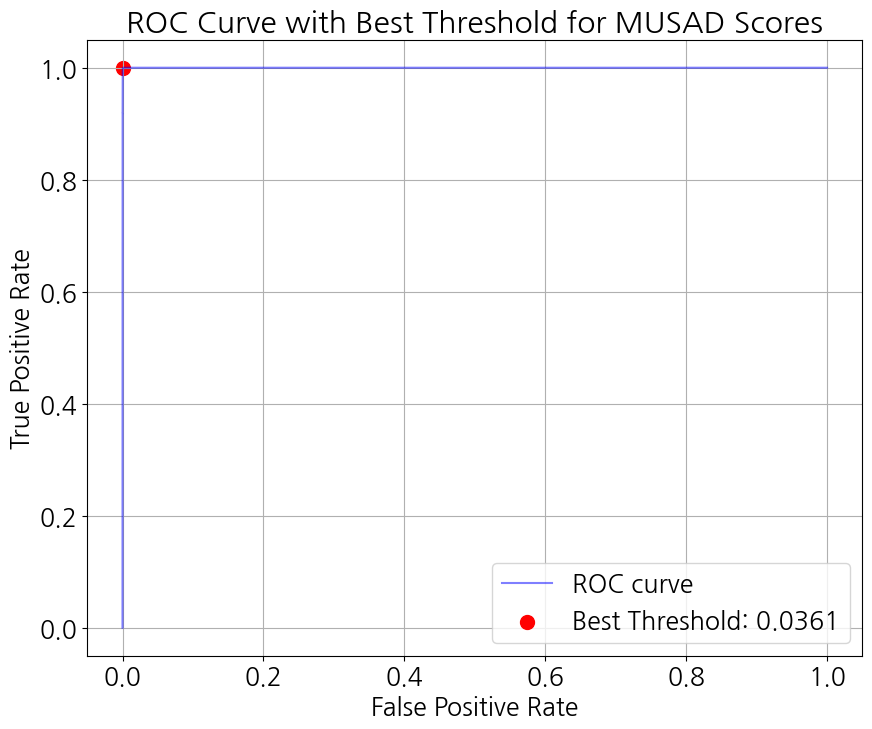

In [46]:
# Plotting
plt.figure(figsize=(10, 8))

# ROC curve
plt.plot(fpr, tpr, label='ROC curve', color='blue', alpha=0.5)
plt.title('ROC Curve with Best Threshold for MUSAD Scores')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
best_threshold_index = np.argmin(distance)
# Best threshold point
plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], color='red', s=100, label=f'Best Threshold: {threshold[best_threshold_index]:.4f}')

plt.legend()
plt.grid(True)
plt.show()


Text(0.5, 1.0, 'Test Data')

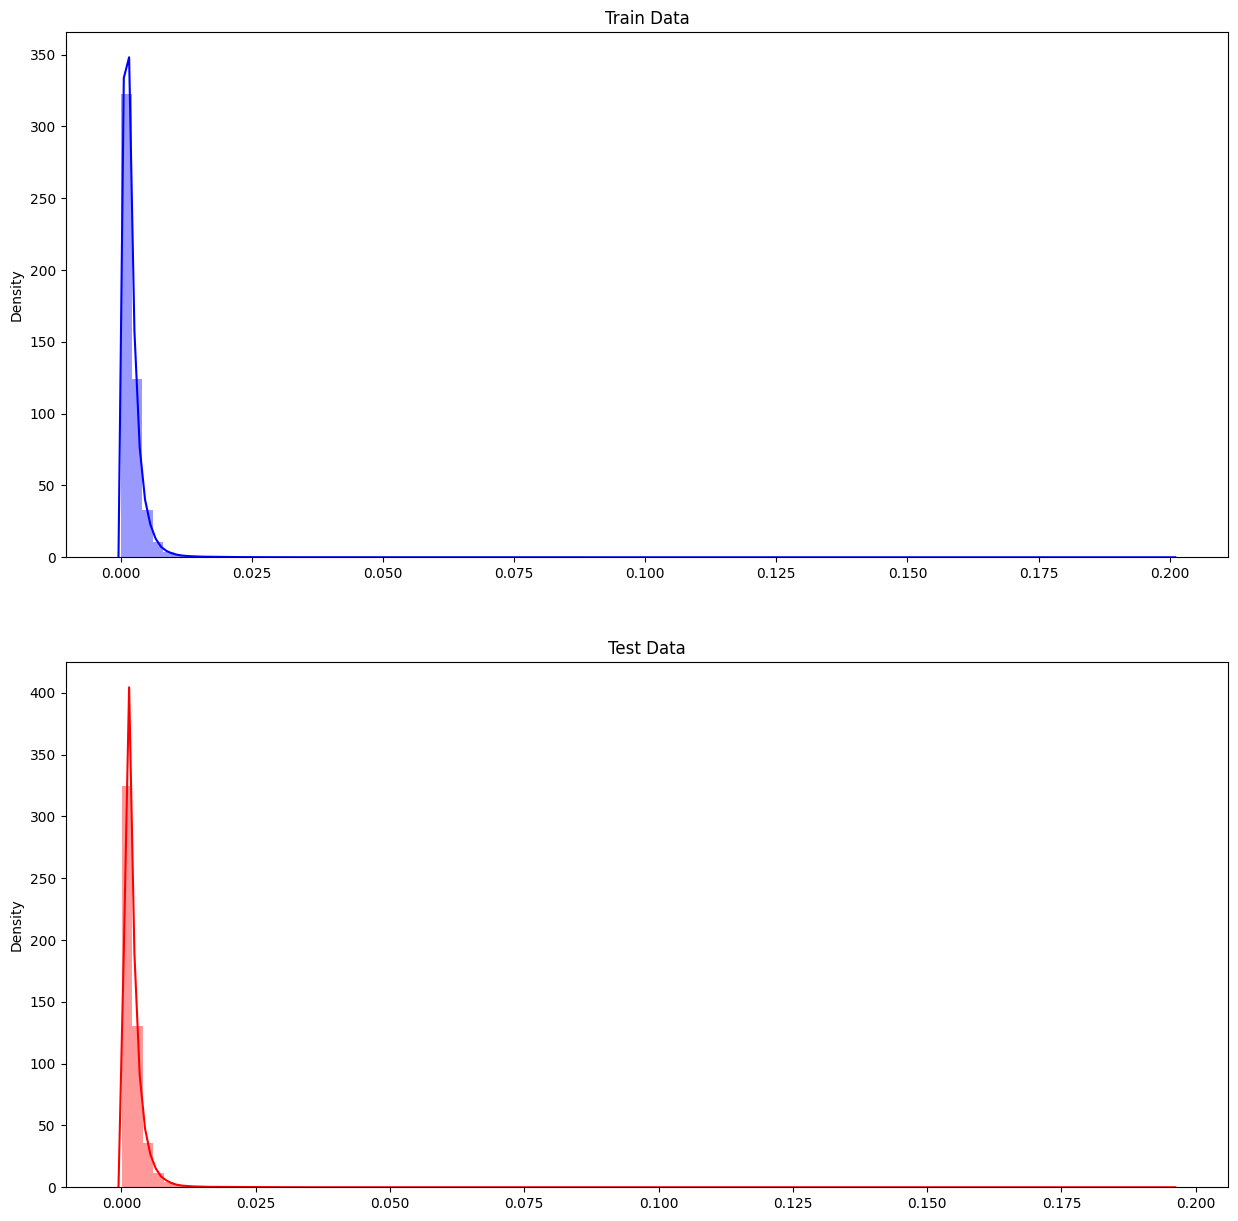

In [479]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15, 15))
sns.distplot(musad_train, bins=100, kde=True, color='blue', ax=ax1)
sns.distplot(musad_test, bins=100, kde=True, color='red', ax=ax2)
ax1.set_title("Train Data")
ax2.set_title("Test Data")

In [480]:
# 임계값은 0.03로 함
mmerged_data = pd.concat([X_normal_train, X_normal_test])
musad_scores = pd.DataFrame(index=mmerged_data.index)
musad_scores['score'] = list(np.hstack([musad_train, musad_test]))

musad_scores['anomaly'] = best_threshold < musad_scores['score']
musad_scores.head()

,score,anomaly
796230,0.003023,False
2462292,0.000909,False
1867287,0.000687,False
1006252,0.001894,False
1190323,0.000381,False


In [481]:
print(best_threshold)

0.03610327


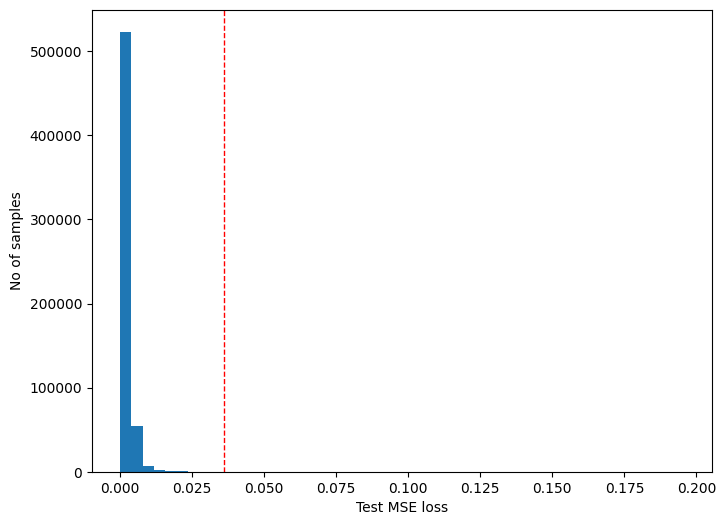

 test 데이터의 불량예측 개수:  221


In [482]:
# 시각화
plt.figure(figsize=(8,6))
plt.hist(musad_test, bins=50)
plt.xlabel("Test MSE loss")
plt.ylabel("No of samples")
plt.axvline(best_threshold, color='red', linestyle='--', linewidth=1)
plt.show()
# test 데이터의 불량 갯수(임계치 기준)
test_Y_normal = [x > best_threshold for x in musad_test]
print(" test 데이터의 불량예측 개수: ", np.sum(test_Y_normal))

In [483]:
abnormal_df =abnormal_data.copy()
# 불필요한 변수 삭제
abnormal_df = abnormal_df.drop(['설비 이상신호'], axis=1)
abnomal_dataset = CustomDataset(abnormal_df)
abnomal_dataloader = DataLoader(abnomal_dataset, batch_size=64)
# 모두 비정상 값 복원오차 값 도출
Musad_abnormal,_,_ = testing(MUSADmodel, abnomal_dataloader)

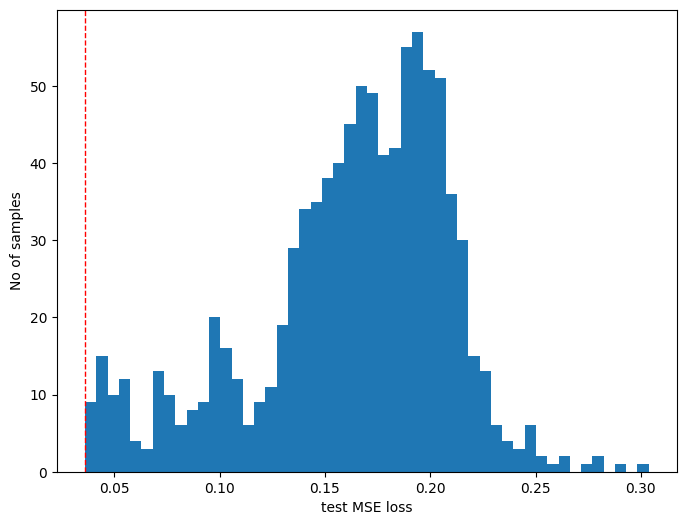

이상점으로 예측한 개수:  932


In [484]:
# 모두 비정상인 값 예측
# 시각화
plt.figure(figsize=(8,6))
plt.hist(Musad_abnormal, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.axvline(best_threshold, color='red', linestyle='--', linewidth=1)
plt.show()
# 이상점으로 판단한 데이터 확인
test_N_abnormal = [x > best_threshold for x in Musad_abnormal]
print("이상점으로 예측한 개수: ", np.sum(test_N_abnormal))

In [485]:
from sklearn.metrics import confusion_matrix
# 결과 값을 통한 정량적 지표 확인
# 실제 양품 불량으로 결합
true = np.concatenate([np.zeros(len(y_normal_test)), np.ones(len(abnormal_data))])
# 예측한 양품, 불량으로 결합
prediction = np.concatenate([test_Y_normal, test_N_abnormal])
musadpredict = prediction
# 혼동 행렬
confusion_matrix(true, prediction)

array([[587537,    221],
       [     1,    932]])

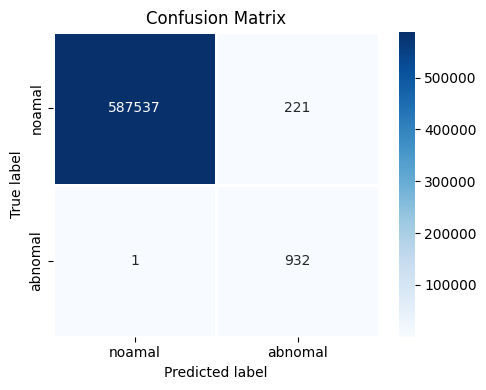

In [486]:
cm = confusion_matrix(true, prediction)
class_names=['정상','비정상']
fig = plt.figure(figsize=(5,4))
ax = sns.heatmap(cm, annot=True, cmap='Blues', linewidths=1, fmt="d",
 xticklabels=['noamal','abnomal'], yticklabels=['noamal','abnomal'])
ax.set(title='Confusion Matrix',
 ylabel='True label',
 xlabel='Predicted label')
plt.tight_layout()
plt.savefig('memAD_9_9.png')

In [487]:
from sklearn.metrics import classification_report
print(classification_report(true, prediction, target_names=['normal', 'abnormal']))

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00    587758
    abnormal       0.81      1.00      0.89       933

    accuracy                           1.00    588691
   macro avg       0.90      1.00      0.95    588691
weighted avg       1.00      1.00      1.00    588691



### idsaf

In [504]:
#musad_abnomal_in = pd.DataFrame(musad_abnomal_in)
#musad_abnormal_out = pd.DataFrame(musad_abnormal_out)
#musad_test_in = pd.DataFrame(musad_test_in)
#musad_test_out = pd.DataFrame(musad_test_out)


musad_abnomal_in.columns =  ['건조 1존 OP', '건조 2존 OP', '건조로 온도 1 Zone', '건조로 온도 2 Zone', '세정기',
       '소입1존 OP', '소입2존 OP', '소입3존 OP', '소입4존 OP', '소입로 CP 값', '소입로 CP 모니터 값',
       '소입로 온도 1 Zone', '소입로 온도 2 Zone', '소입로 온도 3 Zone', '소입로 온도 4 Zone',
       '솔트 컨베이어 온도 1 Zone', '솔트 컨베이어 온도 2 Zone', '솔트조 온도 1 Zone',
       '솔트조 온도 2 Zone']
musad_abnormal_out.columns =  ['건조 1존 OP', '건조 2존 OP', '건조로 온도 1 Zone', '건조로 온도 2 Zone', '세정기',
       '소입1존 OP', '소입2존 OP', '소입3존 OP', '소입4존 OP', '소입로 CP 값', '소입로 CP 모니터 값',
       '소입로 온도 1 Zone', '소입로 온도 2 Zone', '소입로 온도 3 Zone', '소입로 온도 4 Zone',
       '솔트 컨베이어 온도 1 Zone', '솔트 컨베이어 온도 2 Zone', '솔트조 온도 1 Zone',
       '솔트조 온도 2 Zone']
musad_test_in.columns =  ['건조 1존 OP', '건조 2존 OP', '건조로 온도 1 Zone', '건조로 온도 2 Zone', '세정기',
       '소입1존 OP', '소입2존 OP', '소입3존 OP', '소입4존 OP', '소입로 CP 값', '소입로 CP 모니터 값',
       '소입로 온도 1 Zone', '소입로 온도 2 Zone', '소입로 온도 3 Zone', '소입로 온도 4 Zone',
       '솔트 컨베이어 온도 1 Zone', '솔트 컨베이어 온도 2 Zone', '솔트조 온도 1 Zone',
       '솔트조 온도 2 Zone']
musad_test_out.columns =  ['건조 1존 OP', '건조 2존 OP', '건조로 온도 1 Zone', '건조로 온도 2 Zone', '세정기',
       '소입1존 OP', '소입2존 OP', '소입3존 OP', '소입4존 OP', '소입로 CP 값', '소입로 CP 모니터 값',
       '소입로 온도 1 Zone', '소입로 온도 2 Zone', '소입로 온도 3 Zone', '소입로 온도 4 Zone',
       '솔트 컨베이어 온도 1 Zone', '솔트 컨베이어 온도 2 Zone', '솔트조 온도 1 Zone',
       '솔트조 온도 2 Zone']

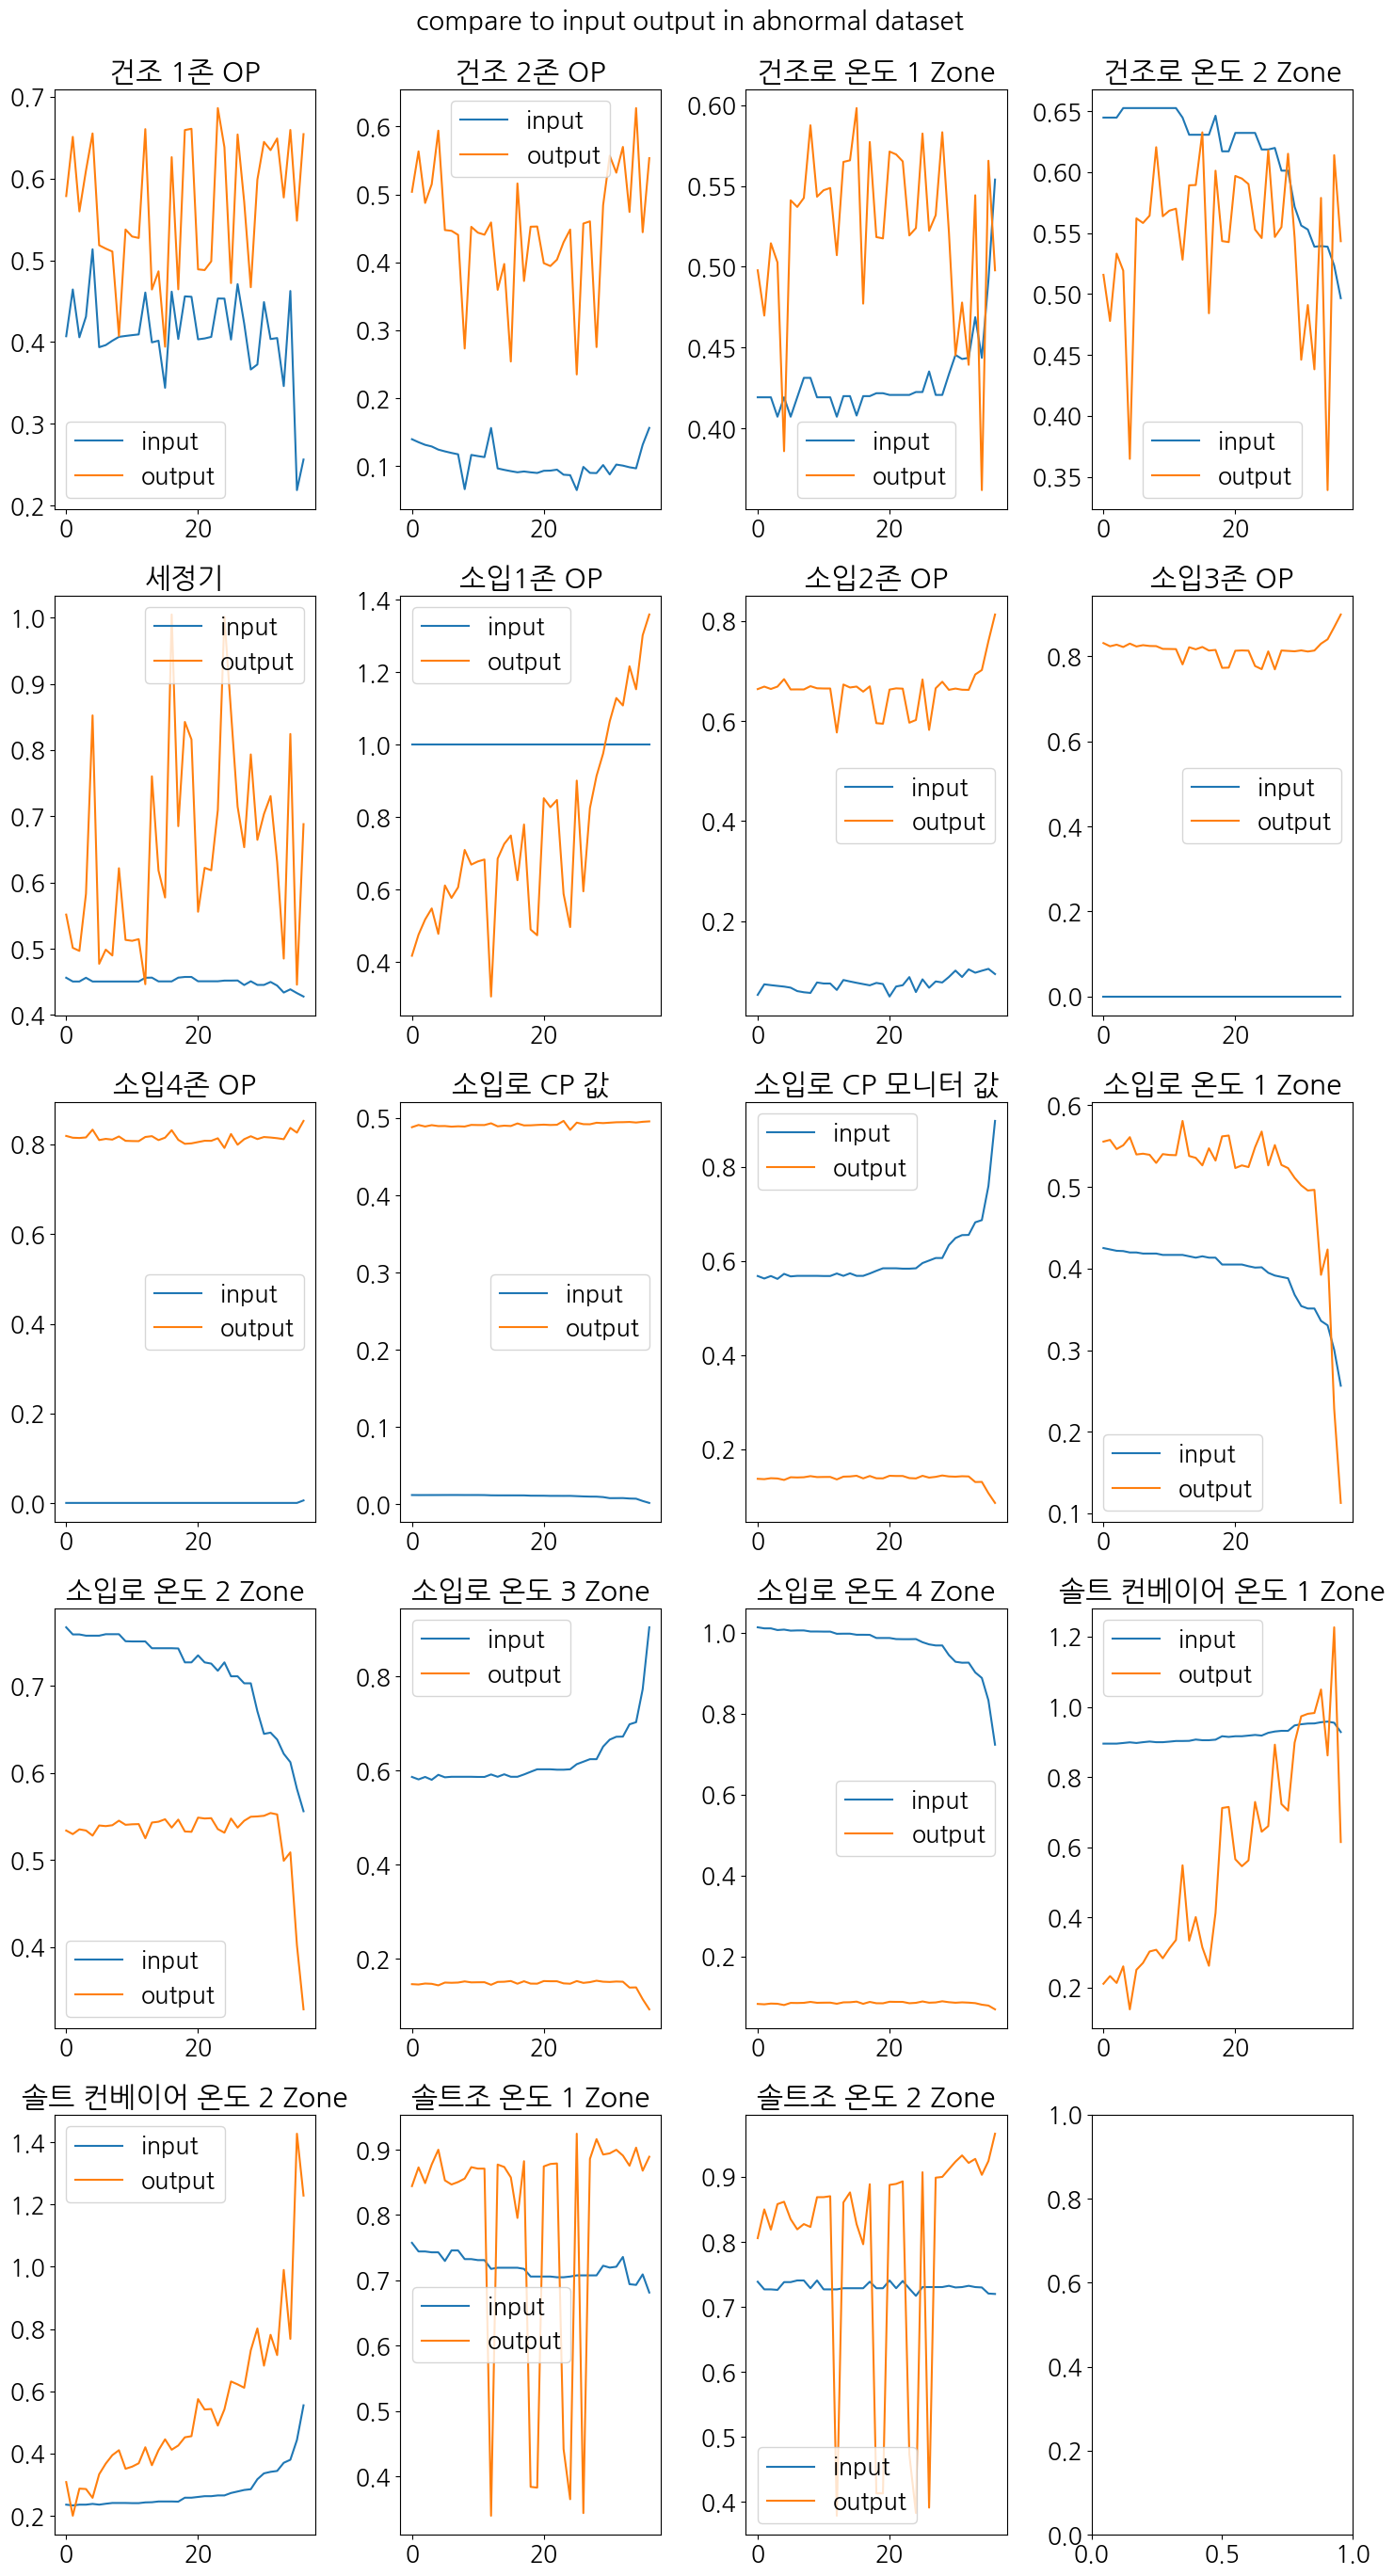

In [535]:
index = 0
fig, axs = plt.subplots(5, 4, figsize=(15, 28))  # 7x2 구조의 subplot 생성
plt.suptitle('compare to input output in abnormal dataset\n',fontsize=20)
for i in range(5):
    for j in range(4):
        if index == 19:
            break
        axs[i, j].plot(musad_abnomal_in[[musad_abnomal_in.columns[index]]], label='input')
        axs[i, j].plot(musad_abnormal_out[[musad_abnormal_out.columns[index]]], label='output')
        axs[i, j].legend()
        axs[i, j].set_title(mae_test_out.columns[index])
        index += 1

plt.tight_layout()
plt.savefig('abnomal_compare_all_feat.png')
plt.show()


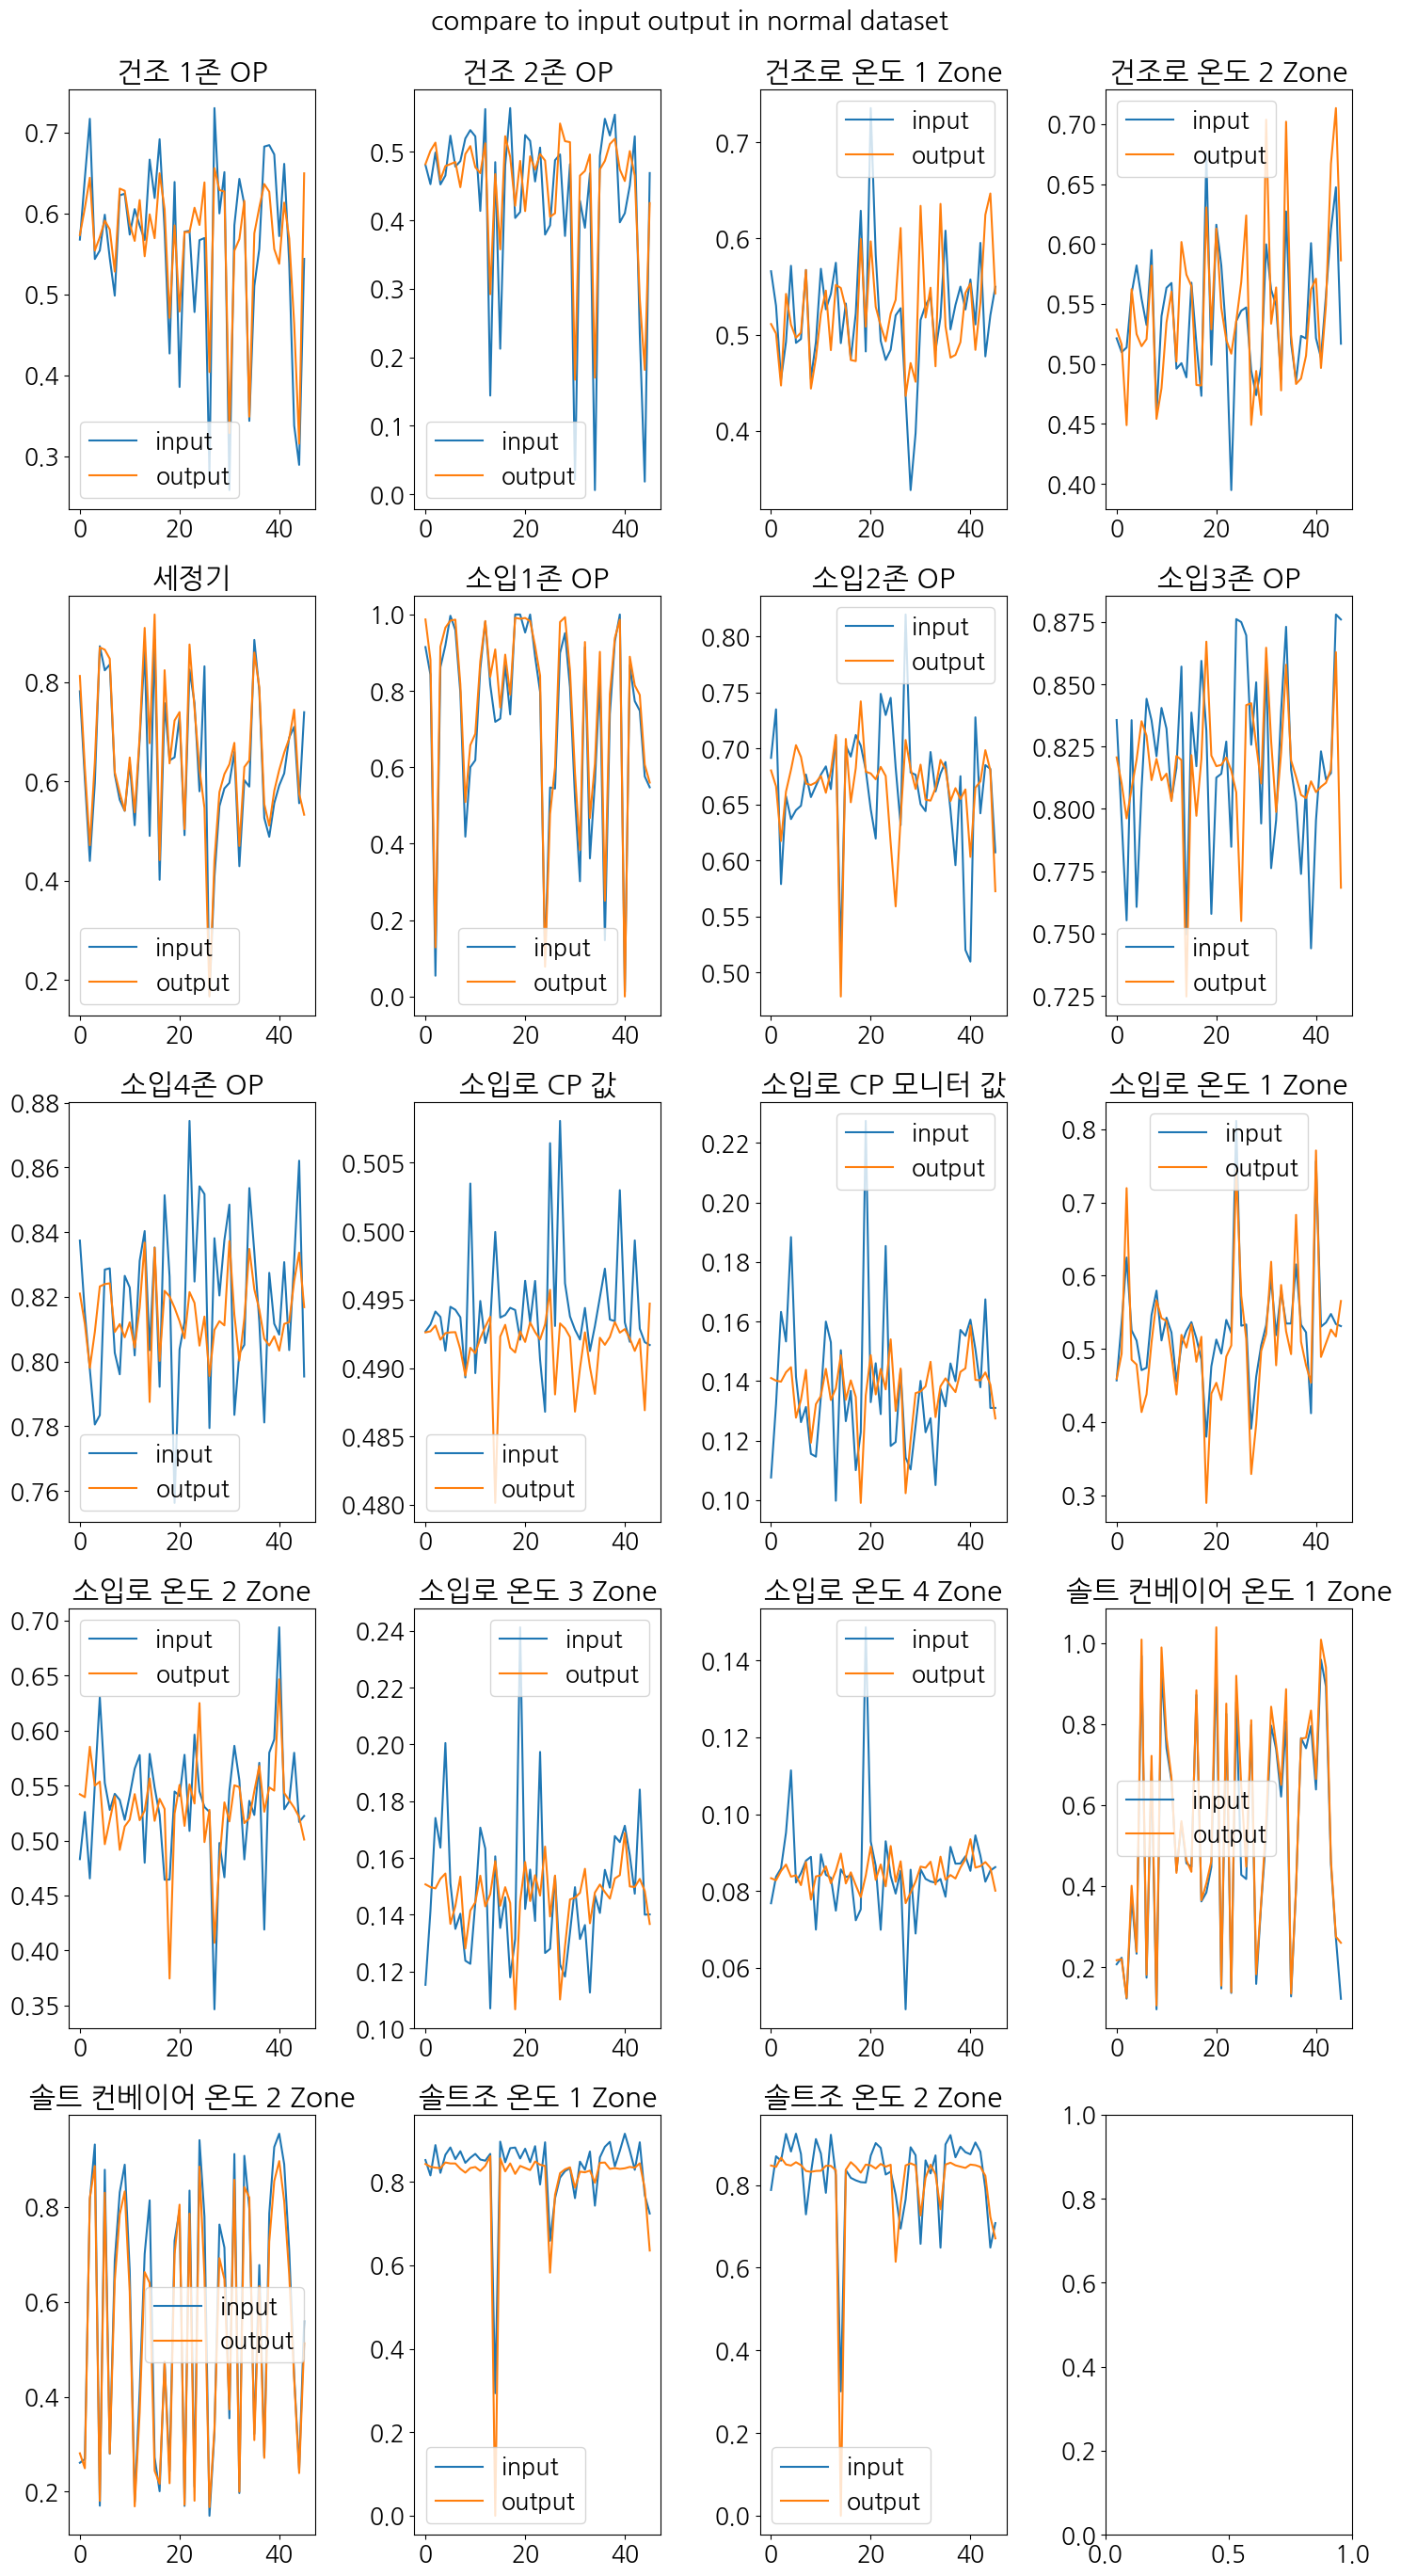

In [536]:
index = 0
fig, axs = plt.subplots(5, 4, figsize=(15, 28))  # 7x2 구조의 subplot 생성
plt.suptitle('compare to input output in normal dataset\n',fontsize=20)
for i in range(5):
    for j in range(4):
        if index == 19:
            break
        axs[i, j].plot(musad_test_in[[musad_test_in.columns[index]]], label='input')
        axs[i, j].plot(musad_test_out[[musad_test_out.columns[index]]], label='output')
        axs[i, j].legend()
        axs[i, j].set_title(mae_test_out.columns[index])
        index += 1

plt.tight_layout()
plt.savefig('nomal_compare_all_feat.png')
plt.show()


## ROC & PR

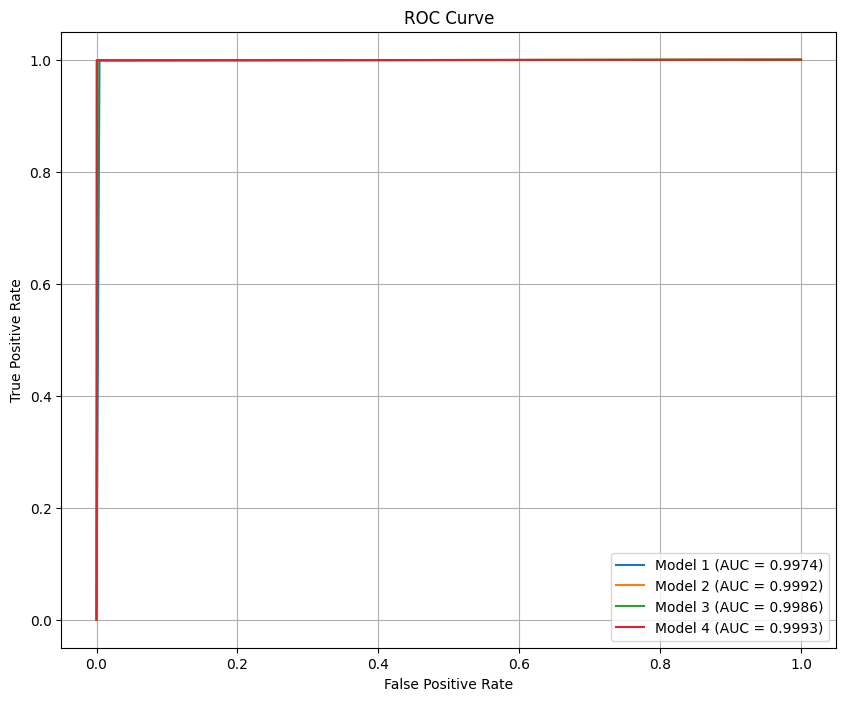

In [418]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# ROC 커브 계산
fpr1, tpr1, _ = roc_curve(true, aepredict)
fpr2, tpr2, _ = roc_curve(true, maepredict)
fpr3, tpr3, _ = roc_curve(true, usadpredict)
fpr4, tpr4, _ = roc_curve(true, musadpredict)

# ROC 커브 그리기
plt.figure(figsize=(10, 8))
plt.plot(fpr1, tpr1, label=f'Model 1 (AUC = {auc(fpr1, tpr1):.4f})')
plt.plot(fpr2, tpr2, label=f'Model 2 (AUC = {auc(fpr2, tpr2):.4f})')
plt.plot(fpr3, tpr3, label=f'Model 3 (AUC = {auc(fpr3, tpr3):.4f})')
plt.plot(fpr4, tpr4, label=f'Model 4 (AUC = {auc(fpr4, tpr4):.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

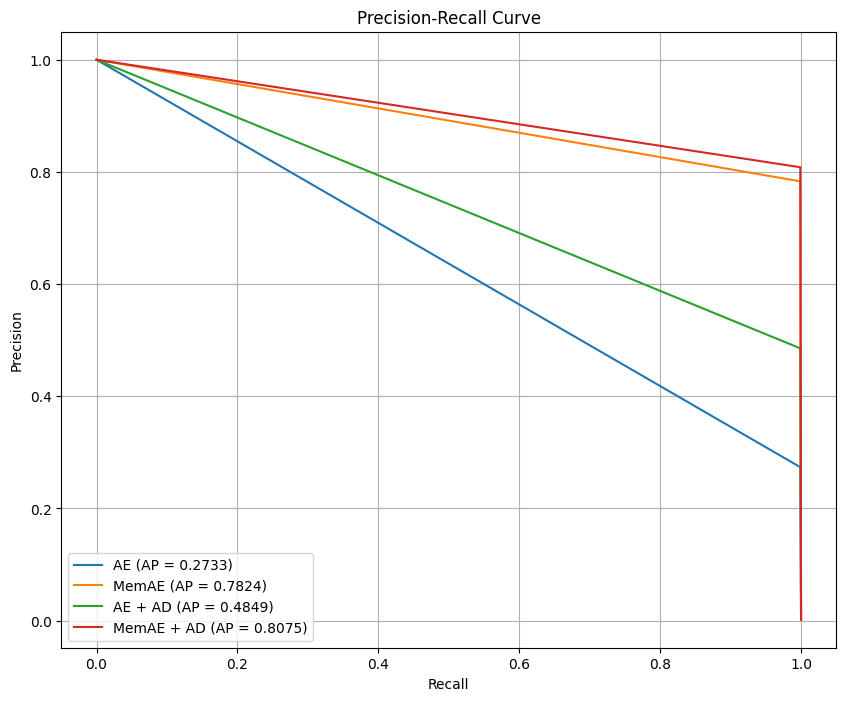

In [417]:
precision1, recall1, _ = precision_recall_curve(true, aepredict)
precision2, recall2, _ = precision_recall_curve(true, maepredict)
precision3, recall3, _ = precision_recall_curve(true, usadpredict)
precision4, recall4, _ = precision_recall_curve(true, musadpredict)

# PR 커브 그리기
plt.figure(figsize=(10, 8))
plt.plot(recall1, precision1, label=f'AE (AP = {average_precision_score(true, aepredict):.4f})')
plt.plot(recall2, precision2, label=f'MemAE (AP = {average_precision_score(true, maepredict):.4f})')
plt.plot(recall3, precision3, label=f'AE + AD (AP = {average_precision_score(true, usadpredict):.4f})')
plt.plot(recall4, precision4, label=f'MemAE + AD (AP = {average_precision_score(true, musadpredict):.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
